# Combined Exercise Notebook for 10_Graph_Transformers

This notebook contains all exercise notebooks from the 10_Graph_Transformers folder:

- code01_exercise.ipynb
- code02_exercise.ipynb
- code03_exercise.ipynb
- code04_exercise.ipynb

**Generated on:** combine_notebooks.py


# --------------------------------------------------------------------------------
# Code01 Exercise
# --------------------------------------------------------------------------------


# Lecture : Graph Transformers & Graph ViT

## Lab 01 : Vanilla Graph Transformers (GT without Positional Encoding) -- Exercise

### Xavier Bresson, Guoji Fu

Dwivedi, Bresson, A generalization of transformer networks to graphs, 2020   
https://arxiv.org/pdf/2012.09699.pdf


In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2025_codes/codes/10_Graph_Transformers'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    !pip install dgl==1.0.0 # Install DGL


In [1]:
# Libraries
import dgl
from dgl.data import MiniGCDataset
import dgl.function as fn
import matplotlib.pyplot as plt
import networkx as nx
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import time


# Visualize the artifical graph dataset used in this notebook

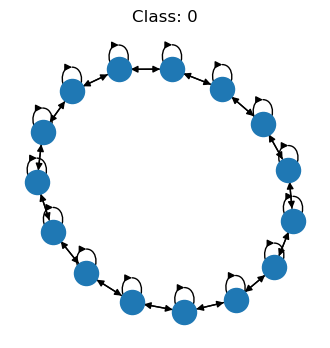

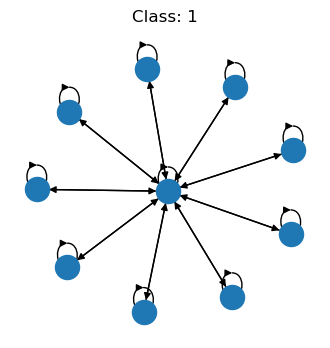

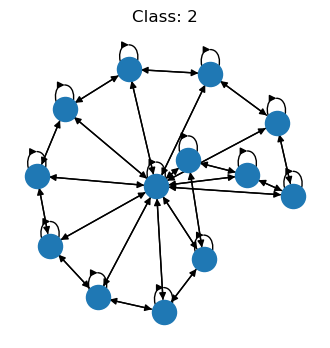

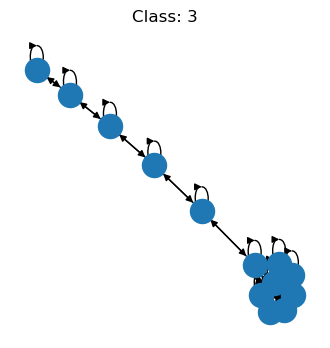

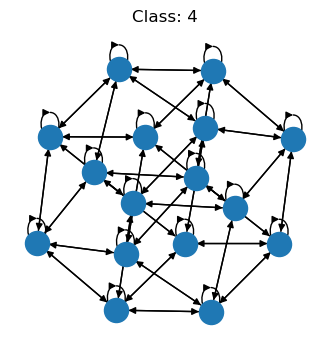

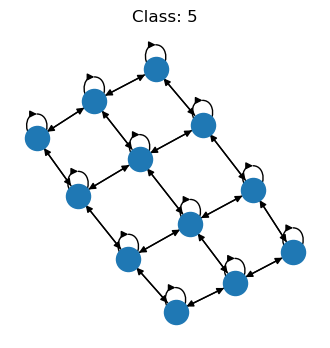

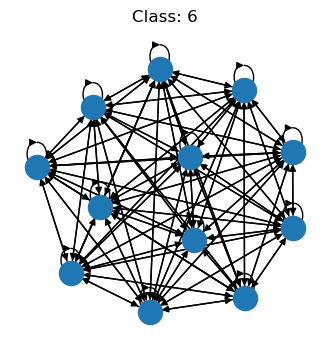

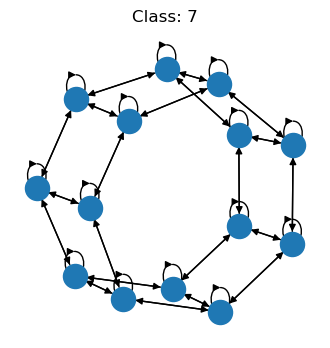

In [2]:
dataset = MiniGCDataset(8, 10, 20) # DGL artificial dataset

# visualise the 8 classes of graphs
for c in range(8):
    graph, label = dataset[c]
    #fig, ax = plt.subplots()
    fig, ax = plt.subplots(figsize=(4,4))
    nx.draw(graph.to_networkx(), ax=ax)
    ax.set_title('Class: {:d}'.format(label))
    plt.show()


# Exercise 1: Generate train, val and test datasets

### Question 1.1: Add node features

**Instructions**:

- Compute the in-degree for each node using ```g.in_degrees()```.

- Reshape and convert the in-degrees to a floating-point tensor with shape ```(number_of_nodes, 1)``` using ```.view(-1, 1).float()```.

- Assign node features to graphs by storing these features in the ```ndata``` dictionary with the key ```'feat'```: ```g.ndata['feat']```.

In [3]:
# Add node features to graphs
def add_node_edge_features(dataset):
    for (graph,_) in dataset:
        ###############################################
        # YOUR CODE STARTS
        ###############################################

        graph.ndata['feat'] = graph.in_degrees().view(-1,1).float()  # node feature: node degree

        ###############################################
        # YOUR CODE ENDS
        ###############################################

    return dataset


In [4]:
# Generate graph datasets
trainset = MiniGCDataset(350, 10, 20)
testset = MiniGCDataset(100, 10, 20)
valset = MiniGCDataset(100, 10, 20)
trainset = add_node_edge_features(trainset)
testset = add_node_edge_features(testset)
valset = add_node_edge_features(valset)
print(trainset[0])

(Graph(num_nodes=15, num_edges=45,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={}), tensor(0))


### Question 1.2: Define the collate function to prepare a batch of DGL graphs and test it

**Instructions:**

- Use ```map()``` and ```zip()``` to unpack the samples into separate graphs and labels lists.

- Use DGL's batch function ```dgl.batch()``` to combine the list of individual graphs into a single batched graph.

- Transform the list of labels into a PyTorch tensor using ```torch.tensor()```.

In [5]:
# collate function prepares a batch of graphs, labels and other graph features (if needed)
def collate(samples):
    # Input sample is a list of pairs (graph, label)
    ###############################################
    # YOUR CODE STARTS
    ###############################################
    graphs, labels = map(list, zip(*samples))
    batch_graphs = dgl.batch(graphs)  # batch of graphs
    batch_labels = torch.tensor(labels)  # batch of labels (here class label)
    ###############################################
    # YOUR CODE ENDS
    ###############################################

    return batch_graphs, batch_labels


In [6]:
# Generate a batch of graphs
batch_size = 10
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)
batch_graphs, batch_labels = list(train_loader)[0]
print(batch_graphs)
print(batch_labels)
batch_x = batch_graphs.ndata['feat']
print('batch_x:',batch_x.size())

Graph(num_nodes=142, num_edges=1102,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={})
tensor([3, 0, 6, 6, 5, 0, 7, 7, 5, 3])
batch_x: torch.Size([142, 1])


# Exercise 2: Design the class of vanilla GraphTransformer networks with DGL

Node update equation:  

**Graph Transformer Layer Updates:**

$$\bar{h}^{\ell} = h^{\ell} + \text{gMHA}(\text{LN}(h^{\ell})) \in \mathbb{R}^{N\times d}$$

$$h^{\ell+1} = \bar{h}^{\ell} + \text{MLP}(\text{LN}(\bar{h}^{\ell})) \in \mathbb{R}^{N\times d}$$

**Graph Multi-Head Attention (gMHA):**

$$\text{gMHA}(h) = \text{Concat}_{k=1}^H \left( \text{gHA}(h_k) \right) W_O \in \mathbb{R}^{N\times d}$$

where $h_k \in \mathbb{R}^{N\times d'=d/H}$ and $W_O \in \mathbb{R}^{d\times d}$

**Graph Head Attention (gHA):**

$$\text{gHA}(h) = \text{Softmax}\left( A_G \odot \frac{QK^T}{\sqrt{d'}} \right) V \in \mathbb{R}^{N\times d'=d/H}$$

where $A_G \in \mathbb{R}^{N\times N}$ is the graph adjacency matrix

**Point-wise Attention Formula:**

$$\text{gHA}(h)_i = \sum_{j\in \mathcal{N}_i} \underbrace{\frac{\exp(q_i^T k_j/\sqrt{d'})}{ \sum_{j'\in\mathcal{N}_i} \exp(q_i^T k_{j'}/\sqrt{d'}) }}_{\text{graph attention score}_{ij}} v_j$$

**Query, Key, Value Projections:**

$$Q = h_k W_Q, \quad K = h_k W_K, \quad V = h_k W_V \in \mathbb{R}^{N\times d'=d/H}$$

where $W_Q, W_K, W_V \in \mathbb{R}^{d'\times d'}$

**Input Embedding:**

$$h^{\ell=0} = \text{LL}(h_0) \in \mathbb{R}^{N\times d}$$

### Implement a MLP layer for classification

In [11]:
# class MLP layer for classification
class MLP_layer(nn.Module):

    def __init__(self, input_dim, output_dim, L=2): # L = nb of hidden layers
        super(MLP_layer, self).__init__()
        list_FC_layers = [ nn.Linear( input_dim, input_dim, bias=True ) for l in range(L) ]
        list_FC_layers.append(nn.Linear( input_dim, output_dim , bias=True ))
        self.FC_layers = nn.ModuleList(list_FC_layers)
        self.L = L

    def forward(self, x):
        y = x
        for l in range(self.L):
            y = self.FC_layers[l](y)
            y = torch.relu(y)
        y = self.FC_layers[self.L](y)
        return y

### Question 2.1: Implement a Graph Multi-Head Attention (MHA) Layer with DGL

**Instructions:**

- *Step 1 of message-passing with DGL:* Pass node feature and edge features along edges (src/j => dst/i) by:
    - *Step 1.1:* Compute $q_i^T * k_j$. You may use ```edges.dst[]``` for ```i, edges.src[]``` for ```j

    - *Step 1.2:* Compute $\textrm{exp}_{ij} = \exp( q_i^T * k_j / \sqrt{d'} )$, ```size=(E,K,1)```.

    - *Step 1.3:* Obtain ```V``` by ```edges.src['V'], size=(E,K,d')```.

- *Step 2 of message-passing with DGL:* Define a reduce function that
    - *Step 2.1:* Use ```nodes.mailbox[]``` to collects all messages ```= {vj, eij}``` sent to node dst/i with *Step 1*.
    
    - *Step 2.2:* Sum/mean over the graph neigbors ```j``` in ```Ni```.

- Assign ```Q, K, V```  to graphs by storing them in the ndata dictionary with the keys ```'Q', 'K', 'V'```: ```g.ndata['Q'], g.ndata['K'], g.ndata['V']``` and reshape them using ```.view(-1, num_heads, head_hidden_dim)```.

In [7]:
# class graph multi head attention layer
class graph_MHA_layer(nn.Module): # MHA = Multi Head Attention

    def __init__(self, hidden_dim, head_hidden_dim, num_heads): # hidden_dim = d
        super().__init__()
        self.head_hidden_dim = head_hidden_dim # head_hidden_dim = d' = d/K
        self.num_heads = num_heads # number of heads = K
        self.WQ = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True) # define K x WQ matrix of size=(d',d')
        self.WK = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True)
        self.WV = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True)

    # Step 1 of message-passing with DGL:
    def message_func(self, edges):
        ###############################################
        # YOUR CODE STARTS
        ###############################################
        # Step 1.1: Compute q_i^T * k_j, size=(E,K,1), edges.src/dst[].size=(E,K,d')
        qi = edges.dst['Q'] # size=(E,K,d')
        kj = edges.src['K'] # size=(E,K,d')
        qikj = (qi * kj).sum(dim=2).unsqueeze(2)

        # Step 1.2: Compute exp_ij = exp( q_i^T * k_j / sqrt(d') ), size=(E,K,1)
        expij = torch.exp(qikj / torch.sqrt(torch.tensor(self.head_hidden_dim)))

        # Step 1.3: Obtain V, size=(E,K,d')
        vj = edges.src['V'] # size=(E,K,d')
        ###############################################
        # YOUR CODE ENDS
        ###############################################
        return {'expij' : expij, 'vj' : vj}

    # Step 2 of message-passing with DGL:
    def reduce_func(self, nodes):
        ###############################################
        # YOUR CODE STARTS
        ###############################################
        # Step 2.1: Collects all messages= eij
        # size=(N,|Nj|,K,1), |Nj|=num_neighbors
        expij = nodes.mailbox['expij']

        # Step 2.1: Collects all messages= vj
        # size=(N,|Nj|,K,d')
        vj = nodes.mailbox['vj']

        # Step 2.2: Sum/mean over the graph neigbors j in Ni
        # sum_j exp_ij . v_j, size=(N,K,d')
        numerator = (expij * vj).sum(dim=1)

        # sum_j' exp_ij', size=(N,K,1)
        denominator = expij.sum(dim=1)

        # h_i = sum_j score_ij . v_j , where score_ij = exp_ij / sum_j' exp_ij', size=(N,K,d')
        h = numerator / denominator
        ###############################################
        # YOUR CODE ENDS
        ###############################################

        return {'h' : h}

    def forward(self, g, h):
        Q = self.WQ(h) # size=(N, d)
                       # computational trick to compute quickly K linear transformations h_k.WQ of size=(N, d')
                       # first compute linear transformation h.WQ of size=(N, d)
                       # then reshape h.WQ of size=(N, K, d'=d/K)
        K = self.WK(h) # size=(N, d)
        V = self.WV(h) # size=(N, d)

        ###############################################
        # YOUR CODE STARTS
        ###############################################
        g.ndata['Q'] = Q.view(-1, self.num_heads, self.head_hidden_dim) # size=(N, K, d'=d/K)
        g.ndata['K'] = K.view(-1, self.num_heads, self.head_hidden_dim) # size=(N, K, d'=d/K)
        g.ndata['V'] = V.view(-1, self.num_heads, self.head_hidden_dim) # size=(N, K, d'=d/K)

        # compute with DGL the graph MHA
        g.update_all(self.message_func, self.reduce_func)
        ###############################################
        # YOUR CODE ENDS
        ###############################################

        gMHA = g.ndata['h'] # size=(N, K, d'=d/K)
        return gMHA



### Implement a GraphTransformer layer

In [8]:
# class GraphTransformer layer
class GraphTransformer_layer(nn.Module):

    def __init__(self, hidden_dim, num_heads, dropout=0.0):
        super().__init__()
        self.hidden_dim = hidden_dim # hidden_dim = d
        self.num_heads = num_heads # number of heads = K
        self.dropout_mha = nn.Dropout(dropout) # dropout value
        self.dropout_mlp = nn.Dropout(dropout) # dropout value
        self.gMHA = graph_MHA_layer(hidden_dim, hidden_dim//num_heads, num_heads) # graph MHA layer
        self.WO = nn.Linear(hidden_dim, hidden_dim) # LL
        self.layer_norm1 = nn.LayerNorm(hidden_dim)
        self.layer_norm2 = nn.LayerNorm(hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim) # LL1 for MLP
        self.linear2 = nn.Linear(hidden_dim, hidden_dim) # LL2 for MLP

    def forward(self, g, h):

        # Self-attention layer
        h_rc = h # size=(N,d), V=num_nodes, for residual connection
        h = self.layer_norm1(h) # layer normalization, size=(N, d)
        h_MHA = self.gMHA(g, h) # MHA, size=(N, K, d'=d/K)
        h_MHA = h_MHA.view(-1, self.hidden_dim) # size=(N, d)
        h_MHA = self.dropout_mha(h_MHA) # dropout, size=(N, d)
        h_MHA = self.WO(h_MHA) # LL, size=(N, d)
        h = h_rc + h_MHA # residual connection, size=(N, d)

        # Fully-connected layer
        h_rc = h # for residual connection, size=(N, d)
        h = self.layer_norm2(h) # layer normalization, size=(N f, d)
        h_MLP = self.linear1(h) # LL, size=(N, d)
        h_MLP = torch.relu(h_MLP) # size=(N, d)
        h_MLP = self.dropout_mlp(h_MLP) # dropout, size=(N, d)
        h_MLP = self.linear2(h_MLP) # LL, size=(N, d)
        h = h_rc + h_MLP # residual connection, size=(N, d)

        return h

### Question 2.2: Combine all previous defined MLP Layer, GraphTransformer layer to construct the Graph Transformer network

**Instructions:**

- *Input embedding layer:* Initialize a linear layer ```nn.Linear()``` to convert input features into node embeddings.

- *Graph transformer layer:* Initialize a ModuleList ```nn.ModuleList()``` containing ```L``` instances of ```GraphTransformer_layer()```.

- *MLP layer:* Initialize a MLP layer ```MLP_layer()``` for classification.

In [ ]:
# class Graph Transformer network
class GraphTransformer_net(nn.Module):

    def __init__(self, net_parameters):
        super(GraphTransformer_net, self).__init__()
        input_dim = net_parameters['input_dim']
        hidden_dim = net_parameters['hidden_dim']
        output_dim = net_parameters['output_dim']
        num_heads = net_parameters['num_heads']
        L = net_parameters['L']

        ###############################################
        # YOUR CODE STARTS
        ###############################################
        self.embedding_h = nn.Linear(input_dim, hidden_dim)
        self.GraphTransformer_layers = nn.ModuleList([ GraphTransformer_layer(hidden_dim, num_heads) for _ in range(L) ])
        self.MLP_layer = MLP_layer(hidden_dim, output_dim)
        ###############################################
        # YOUR CODE ENDS
        ###############################################

    def forward(self, g, h):
        ###############################################
        # YOUR CODE STARTS
        ###############################################
        # input embedding
        h = self.embedding_h(h) # size=(num_nodes, hidden_dim)

        # graph convnet layers
        for GT_layer in self.GraphTransformer_layers:
            h = GT_layer(g,h) # size=(num_nodes, hidden_dim)

        # MLP classifier
        g.ndata['h'] = h
        y = dgl.mean_nodes(g,'h') # DGL mean function over the neighbors, size=(num_graphs, hidden_dim)
        y = self.MLP_layer(y) # size=(num_graphs, num_classes)
        ###############################################
        # YOUR CODE ENDS
        ###############################################

        return y

### Instantiate a graph Transformer network

In [12]:
# Instantiate one network (testing)
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['hidden_dim'] = 128
net_parameters['output_dim'] = 8 # nb of classes
net_parameters['num_heads'] = 8
net_parameters['L'] = 4
net = GraphTransformer_net(net_parameters)
print(net)
def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('Number of parameters: {} ({:.2f} million)'.format(nb_param, nb_param/1e6))
    return nb_param/1e6
_ = display_num_param(net)

batch_size = 10
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)
batch_graphs, batch_labels = list(train_loader)[0]
batch_x = batch_graphs.ndata['feat']
batch_labels = batch_labels
batch_scores = net(batch_graphs, batch_x)
print(batch_scores.size())


GraphTransformer_net(
  (embedding_h): Linear(in_features=1, out_features=128, bias=True)
  (GraphTransformer_layers): ModuleList(
    (0-3): 4 x GraphTransformer_layer(
      (dropout_mha): Dropout(p=0.0, inplace=False)
      (dropout_mlp): Dropout(p=0.0, inplace=False)
      (gMHA): graph_MHA_layer(
        (WQ): Linear(in_features=128, out_features=128, bias=True)
        (WK): Linear(in_features=128, out_features=128, bias=True)
        (WV): Linear(in_features=128, out_features=128, bias=True)
      )
      (WO): Linear(in_features=128, out_features=128, bias=True)
      (layer_norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (layer_norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (linear1): Linear(in_features=128, out_features=128, bias=True)
      (linear2): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (MLP_layer): MLP_layer(
    (FC_layers): ModuleList(
      (0-1): 2 x Linear(in_features=128, out_features=128, bias=True

c:\Users\64483\miniconda3\envs\gnn_course\lib\site-packages\dgl\backend\pytorch\tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


# Train the network

### Define the accuracy function to compute the prediction accuracy

In [13]:
def accuracy(scores, targets):
    scores = scores.detach().argmax(dim=1)
    acc = (scores==targets).float().sum().item()
    return acc

### Implement the ```run_one_epoch``` function for training and evaluation

In [14]:
def run_one_epoch(net, data_loader, train=True, loss_fc=None, optimizer=None):
    if train:
        net.train() # during training
    else:
        net.eval()  # during inference/test
    epoch_loss = 0
    epoch_acc = 0
    nb_data = 0
    gpu_mem = 0
    for iter, (batch_graphs, batch_labels) in enumerate(data_loader):
        batch_x = batch_graphs.ndata['feat']
        batch_labels = batch_labels
        batch_scores = net.forward(batch_graphs, batch_x)
        loss = loss_fc(batch_scores, batch_labels)
        if train: # during training, run backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_loss += loss.detach().item()
        epoch_acc += accuracy(batch_scores, batch_labels)
        nb_data += batch_labels.size(0)
    epoch_loss /= (iter + 1)
    epoch_acc /= nb_data
    return epoch_loss, epoch_acc, optimizer

### Set up data loaders, initialize the model, and running the training loop for the graph Transformer network

In [15]:
# dataset loaders
train_loader = DataLoader(trainset, batch_size=50, shuffle=True, collate_fn=collate)
test_loader = DataLoader(testset, batch_size=50, shuffle=False, collate_fn=collate)
val_loader = DataLoader(valset, batch_size=50, shuffle=False, drop_last=False, collate_fn=collate)

# Instantiate one network
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['hidden_dim'] = 128
net_parameters['output_dim'] = 8 # nb of classes
net_parameters['num_heads'] = 8
net_parameters['L'] = 4
net = GraphTransformer_net(net_parameters)
_ = display_num_param(net)

# optimizer
loss_fc = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0003)

# training loop
for epoch in range(50):
    start = time.time()
    epoch_train_loss, epoch_train_acc, optimizer = run_one_epoch(net, train_loader, True, loss_fc, optimizer)
    with torch.no_grad():
        epoch_test_loss, epoch_test_acc, _ = run_one_epoch(net, test_loader, False, loss_fc)
        epoch_val_loss, epoch_val_acc, _ = run_one_epoch(net, val_loader, False, loss_fc)
    print('Epoch {}, time {:.4f}, train_loss: {:.4f}, test_loss: {:.4f}, val_loss: {:.4f}'.format(epoch, time.time()-start, epoch_train_loss, epoch_test_loss, epoch_val_loss))
    print('                       train_acc: {:.4f}, test_acc: {:.4f}, val_acc: {:.4f}'.format(epoch_train_acc, epoch_test_acc, epoch_val_acc))


Number of parameters: 432648 (0.43 million)
Epoch 0, time 2.1244, train_loss: 2.0355, test_loss: 1.9231, val_loss: 1.9231
                       train_acc: 0.2057, test_acc: 0.2400, val_acc: 0.2400
Epoch 0, time 2.1244, train_loss: 2.0355, test_loss: 1.9231, val_loss: 1.9231
                       train_acc: 0.2057, test_acc: 0.2400, val_acc: 0.2400
Epoch 1, time 2.0652, train_loss: 1.8517, test_loss: 1.7985, val_loss: 1.7985
                       train_acc: 0.2486, test_acc: 0.2900, val_acc: 0.2900
Epoch 1, time 2.0652, train_loss: 1.8517, test_loss: 1.7985, val_loss: 1.7985
                       train_acc: 0.2486, test_acc: 0.2900, val_acc: 0.2900
Epoch 2, time 2.0361, train_loss: 1.7249, test_loss: 1.6793, val_loss: 1.6793
                       train_acc: 0.2857, test_acc: 0.4400, val_acc: 0.4400
Epoch 2, time 2.0361, train_loss: 1.7249, test_loss: 1.6793, val_loss: 1.6793
                       train_acc: 0.2857, test_acc: 0.4400, val_acc: 0.4400
Epoch 3, time 2.0537, train_loss

## Compare results

| GNN    | train acc | test acc |
| -------- | ------- | ------- |
| GCN  | 0.7829   | 0.7900    |
| GIN | 0.0800     | 0.1000     |
| GAT    | 0.9229    | 0.9400    |
| Vanilla GT    | 0.9229    | 0.9400    |


# --------------------------------------------------------------------------------
# Code02 Exercise
# --------------------------------------------------------------------------------


# Lecture : Graph Transformers & Graph ViT

## Lab 02 : Graph Transformers (GT with Positional Encoding) -- Exercise

### Xavier Bresson

Dwivedi, Bresson, A generalization of transformer networks to graphs, 2020   
https://arxiv.org/pdf/2012.09699.pdf


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2025_codes/codes/10_Graph_Transformers'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    !pip install dgl==1.0.0 # Install DGL


In [1]:
# Libraries
import dgl
from dgl.data import MiniGCDataset
import dgl.function as fn
import matplotlib.pyplot as plt
import networkx as nx
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import time
import sys; sys.path.insert(0, 'lib/')
from lib.utils import compute_ncut


# Visualize the artifical graph dataset used in this notebook

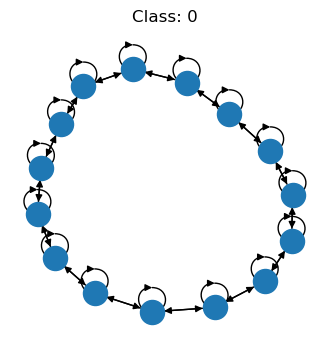

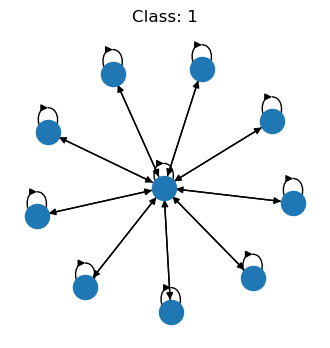

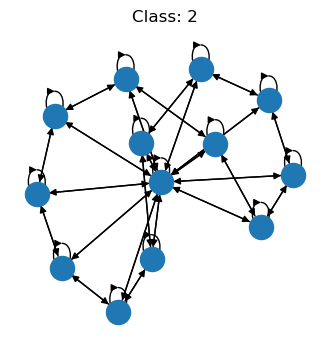

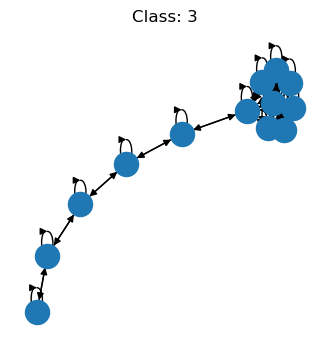

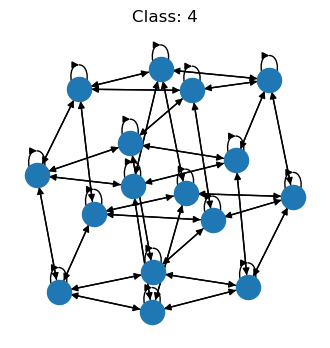

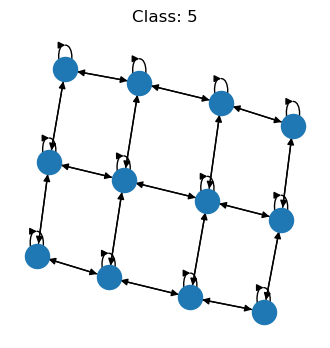

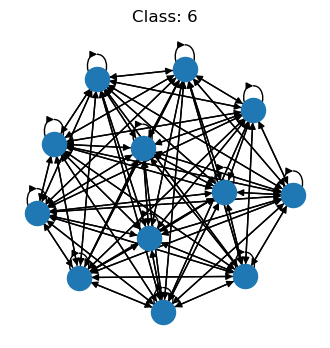

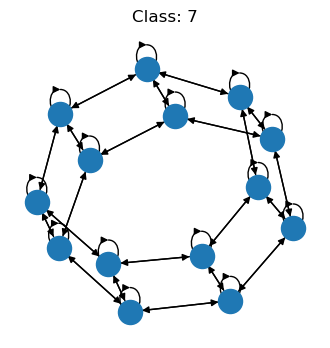

In [2]:
dataset = MiniGCDataset(8, 10, 20) # DGL artificial dataset

# visualise the 8 classes of graphs
for c in range(8):
    graph, label = dataset[c]
    #fig, ax = plt.subplots()
    fig, ax = plt.subplots(figsize=(4,4))
    nx.draw(graph.to_networkx(), ax=ax)
    ax.set_title('Class: {:d}'.format(label))
    plt.show()


# Exercise 1: Generate train, val and test datasets



### Question 1.1: Use Laplacian eigenvectors as positional encoding

**Instructions:**

- *Step 1:* Compute the (normalized) Laplacian operator: $L = I - D^{-1/2}AD^{-1/2}$. You may use ```g.adj().to_dense(), g.in_degree(), torch.eye()``` for computing the adjacency matrix $A$, node degree matrix $D$, and the identity matrix $I$, respectively.

- *Step 2:* Compute the eigenvectors and eigenvalues of the Laplacian operator using eigenvalue decomposition (EVD): ```torch.linalgeig()```.

- *Step 3:* Convert the eigenvectors and eigenvalues into real values, e.g., ```X_real = X.real```. (Think of when a matrix has all real-values eigenvalues and eigenvectors and when it doesn't)

- *Step 4:* Sort the Eigenvectors in increasing order of eigenvalues, ```X_sorted = X[:, Y.argsort()]```.

- *Step 5:* Select the first non-trivial "pos_enc_dim" eigenvector.

In [3]:
# Laplacian eigenvectors as positional encoding
def LapEig_positional_encoding(g, pos_enc_dim):
    ###############################################
    # YOUR CODE STARTS
    ###############################################
    # Step 1
    # Compute the Adjacency matrix
    Adj = g.adj().to_dense() # size=(N,N)
    # Inverse and sqrt of degree matrix
    Dn = g.in_degrees().float() # size=(N,)
    Dn_sqrt_inv = torch.pow(Dn, -0.5)
    Dn_sqrt_inv[torch.isinf(Dn_sqrt_inv)] = 0
    # Compute Laplacian operator
    Eye = torch.eye(g.num_nodes()) # size=(N,N)
    Dn_sqrt_inv_mat = torch.diag(Dn_sqrt_inv) # size=(N,N)
    Lap = Eye -  Dn_sqrt_inv_mat @ Adj @ Dn_sqrt_inv_mat

    # Step 2
    # Compute full EVD of Lap
    # each column of EigVec is an eigenvector
    EigVal, EigVec = torch.linalg.eig(Lap) # EigVal: size=(N,), EigVec: size=(N,N)

    # Step 3
    # Make eig real
    EigVal, EigVec = EigVal.real, EigVec.real

    # Step 4
    # sort in increasing order of eigenvalues
    EigVec = EigVec[:, EigVal.argsort()]

    # Step 5
    # select the first non-trivial "pos_enc_dim" eigenvector
    EigVec = EigVec[:, 1:pos_enc_dim+1]
    ###############################################
    # YOUR CODE ENDS
    ###############################################

    return EigVec

### Question 1.2: Add node features and node postional encoding features to graphs

**Instructions:**

- Assign node features to graphs by storing node in-degrees in the ```ndata``` dictionary with the key ```'feat'```: ```g.ndata['feat']```.

- Assign node positional encoding features to graphs by storing these features in the ```ndata``` dictionary with the key ```'pos_enc'```: ```g.ndata['pos_enc']```.


In [4]:
# Add node and positional encoding features to graphs
pos_enc_dim = 2 # dimension of PE
def add_node_edge_features(dataset):
    for (graph,_) in dataset:
        ###############################################
        # YOUR CODE STARTS
        ###############################################
        # Assign Laplacian eigenvectors as positional encoding features to graphs
        graph.ndata['pos_enc'] = LapEig_positional_encoding(graph, pos_enc_dim) # size=(num_nodes, pos_enc_dim)
        ###############################################
        # YOUR CODE ENDS
        ###############################################

    return dataset

### Generate graph datasets

In [5]:
# Generate graph datasets
trainset = MiniGCDataset(350, 10, 20)
testset = MiniGCDataset(100, 10, 20)
valset = MiniGCDataset(100, 10, 20)
trainset = add_node_edge_features(trainset)
testset = add_node_edge_features(testset)
valset = add_node_edge_features(valset)
print(trainset[0])


(Graph(num_nodes=15, num_edges=45,
      ndata_schemes={'pos_enc': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={}), tensor(0))


### Visualize positional encoding

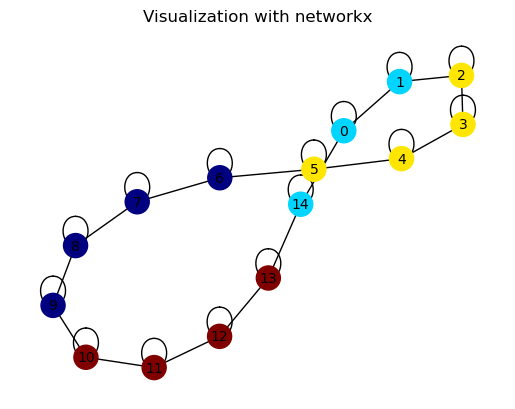

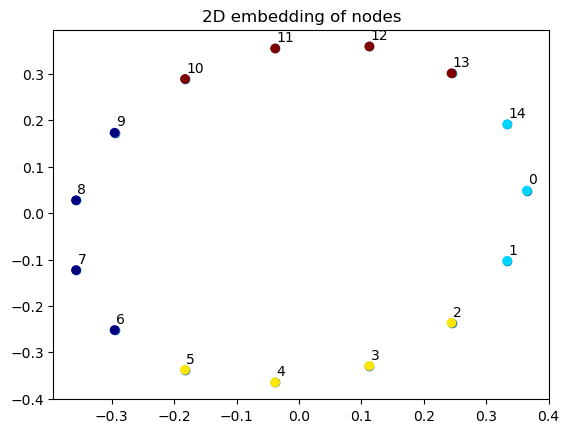

In [6]:
graph = trainset[0][0]

# Visualize graph
fig = plt.figure()
ax = fig.add_subplot(111)
Adj = graph.adj().to_dense()
A_nx = nx.from_numpy_array(Adj.numpy())
C = compute_ncut(Adj.long(), 4)
nx.draw(A_nx, ax=ax, node_color=C, cmap='jet', with_labels=True, font_size=10) # visualise node indexes
ax.title.set_text('Visualization with networkx')
plt.show()

# plot 2D coordinates
fig = plt.figure()
ax = fig.add_subplot(111)
x = graph.ndata['pos_enc']
ax.scatter(x[:,0], x[:,1])
idx = list(range(graph.number_of_nodes()))
ax.scatter(x[:,0], x[:,1], c=C, cmap='jet')
for i, txt in enumerate(idx):
    ax.annotate(txt, (x[:,0][i], x[:,1][i]), textcoords="offset points", xytext=(1,5))
ax.title.set_text('2D embedding of nodes')
plt.show()


### Define the collate function to prepare a batch of DGL graphs and test it like the previous exercise

In [7]:
# collate function prepares a batch of graphs, labels and other graph features (if needed)
def collate(samples):
    # Input sample is a list of pairs (graph, label)
    graphs, labels = map(list, zip(*samples))
    batch_graphs = dgl.batch(graphs)    # batch of graphs
    batch_labels = torch.tensor(labels) # batch of labels (here class label)
    return batch_graphs, batch_labels


# Generate a batch of graphs
batch_size = 10
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)
batch_graphs, batch_labels = list(train_loader)[0]
print(batch_graphs)
print(batch_labels)
batch_pe = batch_graphs.ndata['pos_enc']
print('batch_pe:',batch_pe.size())


Graph(num_nodes=128, num_edges=788,
      ndata_schemes={'pos_enc': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={})
tensor([4, 0, 4, 1, 3, 6, 2, 1, 4, 5])
batch_pe: torch.Size([128, 2])


# Exercise 2: Design the class of GraphTransformer networks (with positional encoding)

Node update equation:

**Graph Transformer Layer Updates:**

$$\bar{h}^{\ell} = h^{\ell} + \text{gMHA}(\text{LN}(h^{\ell})) \in \mathbb{R}^{N\times d}$$

$$h^{\ell+1} = \bar{h}^{\ell} + \text{MLP}(\text{LN}(\bar{h}^{\ell})) \in \mathbb{R}^{N\times d}$$

**Graph Multi-Head Attention (gMHA):**

$$\text{gMHA}(h) = \text{Concat}_{k=1}^H \left( \text{gHA}(h_k) \right) W_O \in \mathbb{R}^{N\times d}$$

where $h_k \in \mathbb{R}^{N\times d'=d/H}$ and $W_O \in \mathbb{R}^{d\times d}$

**Graph Head Attention (gHA):**

$$\text{gHA}(h) = \text{Softmax}\left( A_G \odot \frac{QK^T}{\sqrt{d'}} \right) V \in \mathbb{R}^{N\times d'=d/H}$$

where $A_G \in \mathbb{R}^{N\times N}$ is the graph adjacency matrix

**Point-wise Attention Formula:**

$$\text{gHA}(h)_i = \sum_{j\in \mathcal{N}_i} \underbrace{\frac{\exp(q_i^T k_j/\sqrt{d'})}{ \sum_{j'\in\mathcal{N}_i} \exp(q_i^T k_{j'}/\sqrt{d'}) }}_{\text{graph attention score}_{ij}} v_j$$

**Query, Key, Value Projections:**

$$Q = h_k W_Q, \quad K = h_k W_K, \quad V = h_k W_V \in \mathbb{R}^{N\times d'=d/H}$$

where $W_Q, W_K, W_V \in \mathbb{R}^{d'\times d'}$

**Input Embedding with Positional Encoding:**

$$h^{\ell=0} = \text{LL}_1(h_0) + \text{LL}_2(p_0) \in \mathbb{R}^{N\times d}$$

**Positional Encoding:**

$$p_0 = \Phi_{\{2,\ldots,K+1\}} \in \mathbb{R}^{N\times K}$$

**Laplacian Eigendecomposition:**

$$\Delta = \Phi \Lambda \Phi^T \in \mathbb{R}^{N\times N}$$

where $\Delta$ is the graph Laplacian, $\Phi$ contains eigenvectors, and $\Lambda$ contains eigenvalues.

### Implement a MLP layer for classification like the previous exercise

In [8]:
# class MLP layer for classification
class MLP_layer(nn.Module):

    def __init__(self, input_dim, output_dim, L=2): # L = nb of hidden layers
        super(MLP_layer, self).__init__()
        list_FC_layers = [ nn.Linear( input_dim, input_dim, bias=True ) for l in range(L) ]
        list_FC_layers.append(nn.Linear( input_dim, output_dim , bias=True ))
        self.FC_layers = nn.ModuleList(list_FC_layers)
        self.L = L

    def forward(self, x):
        y = x
        for l in range(self.L):
            y = self.FC_layers[l](y)
            y = torch.relu(y)
        y = self.FC_layers[self.L](y)
        return y



### Implement a Graph Multi-Head Attention (MHA) Layer with DGL like the previous exercise

In [9]:
# class graph multi head attention layer
class graph_MHA_layer(nn.Module): # MHA = Multi Head Attention

    def __init__(self, hidden_dim, head_hidden_dim, num_heads): # hidden_dim = d
        super().__init__()
        self.head_hidden_dim = head_hidden_dim # head_hidden_dim = d' = d/K
        self.num_heads = num_heads # number of heads = K
        self.WQ = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True) # define K x WQ matrix of size=(d',d')
        self.WK = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True)
        self.WV = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True)

    # Step 1 of message-passing with DGL:
    #   Node feature and edge features are passed along edges (src/j => dst/i)
    def message_func(self, edges):
        # Step 1.1: Compute q_i^T * k_j, size=(E,K,1), edges.src/dst[].size=(E,K,d')
        qikj = (edges.src['K'] * edges.dst['Q']).sum(dim=2).unsqueeze(2)

        # Step 1.2: Compute exp_ij = exp( q_i^T * k_j / sqrt(d') ), size=(E,K,1)
        expij = torch.exp( qikj / torch.sqrt(torch.tensor(self.head_hidden_dim)) )

        # Step 1.3: Obtain V
        vj = edges.src['V'] # size=(E,K,d')

        return {'expij' : expij, 'vj' : vj}

    # Step 2 of message-passing with DGL:
    #   Reduce function collects all messages={hj, eij} sent to node dst/i with Step 1
    #                   and sum/mean over the graph neigbors j in Ni
    def reduce_func(self, nodes):
        # Step 2.1: Collects all messages= eij
        # size=(N,|Nj|,K,1), |Nj|=num_neighbors
        expij = nodes.mailbox['expij']

        # Step 2.1: Collects all messages= vj
        # size=(N,|Nj|,K,d')
        vj = nodes.mailbox['vj']

        # Step 2.2: Sum/mean over the graph neigbors j in Ni
        # sum_j exp_ij . v_j, size=(N,K,d')
        numerator = torch.sum( expij * vj, dim=1 )

        # sum_j' exp_ij', size=(N,K,1)
        denominator = torch.sum( expij, dim=1 )

        # h_i = sum_j score_ij . v_j , where score_ij = exp_ij / sum_j' exp_ij', size=(N,K,d')
        h = numerator / denominator

        return {'h' : h}

    def forward(self, g, h):
        Q = self.WQ(h) # size=(N, d)
                       # computational trick to compute quickly K linear transformations h_k.WQ of size=(N, d')
                       # first compute linear transformation h.WQ of size=(N, d)
                       # then reshape h.WQ of size=(N, K, d'=d/K)
        K = self.WK(h) # size=(N, d)
        V = self.WV(h) # size=(N, d)
        g.ndata['Q'] = Q.view(-1, self.num_heads, self.head_hidden_dim) # size=(N, K, d'=d/K)
        g.ndata['K'] = K.view(-1, self.num_heads, self.head_hidden_dim) # size=(N, K, d'=d/K)
        g.ndata['V'] = V.view(-1, self.num_heads, self.head_hidden_dim) # size=(N, K, d'=d/K)
        g.update_all(self.message_func, self.reduce_func) # compute with DGL the graph MHA
        gMHA = g.ndata['h'] # size=(N, K, d'=d/K)
        return gMHA




### Implement a GraphTransformer layer like the previous exercise

In [10]:
# class GraphTransformer layer
class GraphTransformer_layer(nn.Module):

    def __init__(self, hidden_dim, num_heads, dropout=0.0):
        super().__init__()
        self.hidden_dim = hidden_dim # hidden_dim = d
        self.num_heads = num_heads # number of heads = K
        self.dropout_mha = nn.Dropout(dropout) # dropout value
        self.dropout_mlp = nn.Dropout(dropout) # dropout value
        self.gMHA = graph_MHA_layer(hidden_dim, hidden_dim//num_heads, num_heads) # graph MHA layer
        self.WO = nn.Linear(hidden_dim, hidden_dim) # LL
        self.layer_norm1 = nn.LayerNorm(hidden_dim) # layer normalization
        self.layer_norm2 = nn.LayerNorm(hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim) # LL1 for MLP
        self.linear2 = nn.Linear(hidden_dim, hidden_dim) # LL2 for MLP

    def forward(self, g, h):

        # Self-attention layer
        h_rc = h # size=(N,d), V=num_nodes, for residual connection
        h = self.layer_norm1(h) # layer normalization, size=(N, d)
        h_MHA = self.gMHA(g, h) # MHA, size=(N, K, d'=d/K)
        h_MHA = h_MHA.view(-1, self.hidden_dim) # size=(N, d)
        h_MHA = self.dropout_mha(h_MHA) # dropout, size=(N, d)
        h_MHA = self.WO(h_MHA) # LL, size=(N, d)
        h = h_rc + h_MHA # residual connection, size=(N, d)

        # Fully-connected layer
        h_rc = h # for residual connection, size=(N, d)
        h = self.layer_norm2(h) # layer normalization, size=(N, d)
        h_MLP = self.linear1(h) # LL, size=(H, d)
        h_MLP = torch.relu(h_MLP) # size=(N, d)
        h_MLP = self.dropout_mlp(h_MLP) # dropout, size=(N, d)
        h_MLP = self.linear2(h_MLP) # LL, size=(N, d)
        h = h_rc + h_MLP # residual connection, size=(N, d)

        return h




### Question 2.1: Combine all previous defined MLP Layer, GraphTransformer layer to construct the Graph Transformer network (with positional encoding)

**Instructions:**

<!-- - *Input embedding layer:* Initialize a linear layer $LL_1(h_0)$ to convert input features $h_0$ into node embeddings and another linear layer $LL_2(p_0)$ to convert input positional encoding features $p_0$ into positional encoding embeddings. Summing up by $h^{\ell=0} = \textrm{LL}_1(h_0)+\textrm{LL}_2(p_0) \in \mathbb{R}^{N\times d}\ \textrm{(input node feature and positional encoding)}$ -->
- *Input embedding layer:* Initialize a linear layer ```nn.Linear()``` to convert input positional encoding features into node positional encoding embeddings.

In [11]:
# class Graph Transformer network
class GraphTransformer_net(nn.Module):

    def __init__(self, net_parameters):
        super(GraphTransformer_net, self).__init__()
        input_dim = net_parameters['input_dim']
        pos_enc_dim = net_parameters['pos_enc_dim']
        hidden_dim = net_parameters['hidden_dim']
        output_dim = net_parameters['output_dim']
        num_heads = net_parameters['num_heads']
        L = net_parameters['L']

        ###############################################
        # YOUR CODE STARTS
        ###############################################
        self.embedding_pe = nn.Linear(pos_enc_dim, hidden_dim)
        ###############################################
        # YOUR CODE ENDS
        ###############################################
        # self.embedding_e = nn.Linear(1, hidden_dim)
        self.GraphTransformer_layers = nn.ModuleList([ GraphTransformer_layer(hidden_dim, num_heads) for _ in range(L) ])
        self.MLP_layer = MLP_layer(hidden_dim, output_dim)

    def forward(self, g, pe):
        ###############################################
        # YOUR CODE STARTS
        ###############################################
        # input node embedding = positional embedding
        # Compute the linear transformation of the positional embedding
        # You may use "nn.Linear(pos_enc_dim, hidden_dim)"
        h = self.embedding_pe(pe) # size=(num_nodes, hidden_dim)
        ###############################################
        # YOUR CODE ENDS
        ###############################################

        # graph convnet layers
        for GT_layer in self.GraphTransformer_layers:
            h = GT_layer(g,h) # size=(num_nodes, hidden_dim)

        # MLP classifier
        g.ndata['h'] = h
        y = dgl.mean_nodes(g,'h') # DGL mean function over the neighbors, size=(num_graphs, hidden_dim)
        y = self.MLP_layer(y) # size=(num_graphs, num_classes)
        return y




### Question 2.2: Instantiate a graph Transformer network (with pisitional encoding)

In [12]:
# Instantiate one network (testing)
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['pos_enc_dim'] = pos_enc_dim
net_parameters['hidden_dim'] = 128
net_parameters['output_dim'] = 8 # nb of classes
net_parameters['num_heads'] = 8
net_parameters['norm'] = 'BN'
net_parameters['L'] = 4
net = GraphTransformer_net(net_parameters)
print(net)
def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('Number of parameters: {} ({:.2f} million)'.format(nb_param, nb_param/1e6))
    return nb_param/1e6
_ = display_num_param(net)

batch_size = 10
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)
batch_graphs, batch_labels = list(train_loader)[0]

###############################################
# YOUR CODE STARTS
###############################################
batch_pe = batch_graphs.ndata['pos_enc']
###############################################
# YOUR CODE ENDS
###############################################

batch_labels = batch_labels
batch_scores = net(batch_graphs, batch_pe)
print(batch_scores.size())


GraphTransformer_net(
  (embedding_pe): Linear(in_features=2, out_features=128, bias=True)
  (GraphTransformer_layers): ModuleList(
    (0-3): 4 x GraphTransformer_layer(
      (dropout_mha): Dropout(p=0.0, inplace=False)
      (dropout_mlp): Dropout(p=0.0, inplace=False)
      (gMHA): graph_MHA_layer(
        (WQ): Linear(in_features=128, out_features=128, bias=True)
        (WK): Linear(in_features=128, out_features=128, bias=True)
        (WV): Linear(in_features=128, out_features=128, bias=True)
      )
      (WO): Linear(in_features=128, out_features=128, bias=True)
      (layer_norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (layer_norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (linear1): Linear(in_features=128, out_features=128, bias=True)
      (linear2): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (MLP_layer): MLP_layer(
    (FC_layers): ModuleList(
      (0-1): 2 x Linear(in_features=128, out_features=128, bias=Tru

c:\Users\64483\miniconda3\envs\gnn_course\lib\site-packages\dgl\backend\pytorch\tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


# Train the network

In [13]:
def accuracy(scores, targets):
    scores = scores.detach().argmax(dim=1)
    acc = (scores==targets).float().sum().item()
    return acc

def run_one_epoch(net, data_loader, train=True, loss_fc=None, optimizer=None):
    if train:
        net.train() # during training
    else:
        net.eval()  # during inference/test
    epoch_loss = 0
    epoch_acc = 0
    nb_data = 0
    gpu_mem = 0
    for iter, (batch_graphs, batch_labels) in enumerate(data_loader):
        batch_pe = batch_graphs.ndata['pos_enc']
        batch_pe = batch_pe * ( 2 * torch.randint(low=0, high=2, size=(1,pos_enc_dim)).float() - 1.0 ) # randomly flip sign of eigenvectors
        batch_labels = batch_labels
        batch_scores = net.forward(batch_graphs, batch_pe)
        loss = loss_fc(batch_scores, batch_labels)
        if train: # during training, run backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_loss += loss.detach().item()
        epoch_acc += accuracy(batch_scores,batch_labels)
        nb_data += batch_labels.size(0)
    epoch_loss /= (iter + 1)
    epoch_acc /= nb_data
    return epoch_loss, epoch_acc, optimizer


# dataset loaders
train_loader = DataLoader(trainset, batch_size=50, shuffle=True, collate_fn=collate)
test_loader = DataLoader(testset, batch_size=50, shuffle=False, collate_fn=collate)
val_loader = DataLoader(valset, batch_size=50, shuffle=False, drop_last=False, collate_fn=collate)

# Instantiate one network
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['pos_enc_dim'] = pos_enc_dim
net_parameters['hidden_dim'] = 128
net_parameters['output_dim'] = 8 # nb of classes
net_parameters['num_heads'] = 8
net_parameters['L'] = 4
del net
net = GraphTransformer_net(net_parameters)
_ = display_num_param(net)

# optimizer
loss_fc = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0003)

# training loop
start = time.time()
for epoch in range(50):
    epoch_train_loss, epoch_train_acc, optimizer = run_one_epoch(net, train_loader, True, loss_fc, optimizer)
    with torch.no_grad():
        epoch_test_loss, epoch_test_acc, _ = run_one_epoch(net, test_loader, False, loss_fc)
        epoch_val_loss, epoch_val_acc, _ = run_one_epoch(net, val_loader, False, loss_fc)
    print('Epoch {}, time {:.4f}, train_loss: {:.4f}, test_loss: {:.4f}, val_loss: {:.4f}'.format(epoch, time.time()-start, epoch_train_loss, epoch_test_loss, epoch_val_loss))
    print('                       train_acc: {:.4f}, test_acc: {:.4f}, val_acc: {:.4f}'.format(epoch_train_acc, epoch_test_acc, epoch_val_acc))


Number of parameters: 432776 (0.43 million)
Epoch 0, time 2.2073, train_loss: 2.0862, test_loss: 2.0722, val_loss: 2.0724
                       train_acc: 0.1114, test_acc: 0.1600, val_acc: 0.1600
Epoch 0, time 2.2073, train_loss: 2.0862, test_loss: 2.0722, val_loss: 2.0724
                       train_acc: 0.1114, test_acc: 0.1600, val_acc: 0.1600
Epoch 1, time 4.7173, train_loss: 2.0769, test_loss: 2.0700, val_loss: 2.0697
                       train_acc: 0.1343, test_acc: 0.2300, val_acc: 0.2400
Epoch 1, time 4.7173, train_loss: 2.0769, test_loss: 2.0700, val_loss: 2.0697
                       train_acc: 0.1343, test_acc: 0.2300, val_acc: 0.2400
Epoch 2, time 7.4497, train_loss: 2.0671, test_loss: 2.0510, val_loss: 2.0507
                       train_acc: 0.2143, test_acc: 0.1600, val_acc: 0.1600
Epoch 2, time 7.4497, train_loss: 2.0671, test_loss: 2.0510, val_loss: 2.0507
                       train_acc: 0.2143, test_acc: 0.1600, val_acc: 0.1600
Epoch 3, time 9.8379, train_loss

## Compare results

| GNN    | train acc | test acc |
| -------- | ------- | ------- |
| GCN  | 0.7829   | 0.7900    |
| GIN | 0.0800     | 0.1000     |
| GAT    | 0.9229    | 0.9400    |
| Vanilla GT    | 0.9229    | 0.9400    |
| GT (w/ PE)    |1.0000| 1.0000     |


# --------------------------------------------------------------------------------
# Code03 Exercise
# --------------------------------------------------------------------------------


# Lecture : Graph Transformers & Graph ViT

## Lab 03 : Graph Transformers with edge features and DGL (sparse linear algebra) -- Exercise

### Xavier Bresson, Guoji Fu

Dwivedi, Bresson, A generalization of transformer networks to graphs, 2020   
https://arxiv.org/pdf/2012.09699.pdf


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2025_codes/codes/10_Graph_Transformers'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    !pip install dgl==1.0.0 # Install DGL


In [1]:
# Libraries
import pickle
import dgl
import dgl.function as fn
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import time
import networkx as nx
import sys; sys.path.insert(0, 'lib/')
from lib.utils import compute_ncut
from lib.molecules import Dictionary, MoleculeDataset, MoleculeDGL, Molecule
import os, datetime


# Load molecular datasets

In [2]:
# Select dataset
dataset_name = 'QM9_1.4k'; data_folder_pytorch = 'dataset/QM9_1.4k_pytorch/'; data_folder_dgl = 'dataset/QM9_1.4k_dgl/'

# Load the number of atom and bond types
with open(data_folder_pytorch + "atom_dict.pkl" ,"rb") as f: num_atom_type = len(pickle.load(f))
with open(data_folder_pytorch + "bond_dict.pkl" ,"rb") as f: num_bond_type = len(pickle.load(f))
print(num_atom_type)
print(num_bond_type)

# Load the DGL datasets
datasets_dgl = MoleculeDataset(dataset_name, data_folder_dgl)
trainset, valset, testset = datasets_dgl.train, datasets_dgl.val, datasets_dgl.test
print(len(trainset))
print(len(valset))
print(len(testset))
idx = 0
print(trainset[:2])
print(valset[idx])
print(testset[idx])


9
4
Loading datasets QM9_1.4k_dgl...
train, test, val sizes : 1000 200 200
Time: 2.0298s
1000
200
200
([Graph(num_nodes=9, num_edges=20,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}), Graph(num_nodes=9, num_edges=18,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)})], [tensor([-0.2532]), tensor([1.0897])])
(Graph(num_nodes=9, num_edges=18,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}), tensor([0.5060]))
(Graph(num_nodes=9, num_edges=20,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}), tensor([-4.4048]))


# Add positional encoding feature

In [3]:
# Positional encoding as Laplacian eigenvectors
def LapEig_positional_encoding(g, pos_enc_dim):
    Adj = g.adj().to_dense() # Adjacency matrix
    Dn = ( g.in_degrees()** -0.5 ).diag() # Inverse and sqrt of degree matrix
    Lap = torch.eye(g.number_of_nodes()) - Dn.matmul(Adj).matmul(Dn) # Laplacian operator
    EigVal, EigVec = torch.linalg.eig(Lap) # Compute full EVD
    EigVal, EigVec = EigVal.real, EigVec.real # make eig real
    EigVec = EigVec[:, EigVal.argsort()] # sort in increasing order of eigenvalues
    EigVec = EigVec[:,1:pos_enc_dim+1] # select the first non-trivial "pos_enc_dim" eigenvector
    return EigVec

# Add node positional encoding features to graphs
pos_enc_dim = 3 # dimension of PE, QM9
def add_node_edge_features(dataset):
    for (graph,_) in dataset:
        graph.ndata['pos_enc'] = LapEig_positional_encoding(graph, pos_enc_dim) # node positional encoding feature
    return dataset

# Generate graph datasets
trainset = add_node_edge_features(trainset)
testset = add_node_edge_features(testset)
valset = add_node_edge_features(valset)
print(trainset[0])


(Graph(num_nodes=9, num_edges=20,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64), 'pos_enc': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}), tensor([-0.2532]))


# Visualize positional encoding

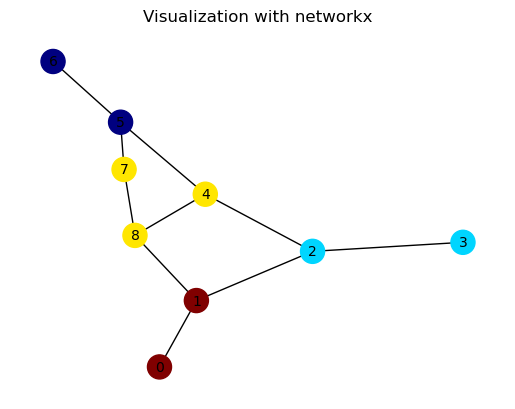

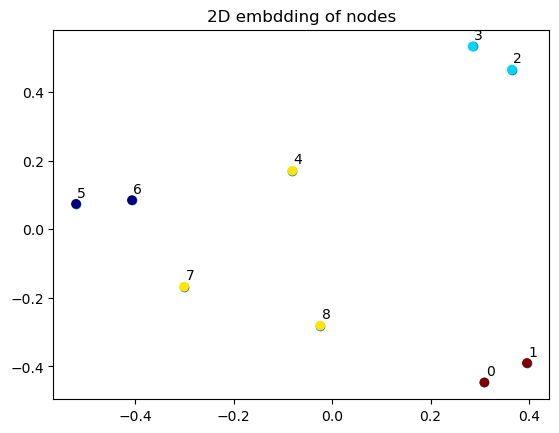

In [4]:
graph = trainset[0][0]

# Visualize graph
fig = plt.figure()
ax = fig.add_subplot(111)
Adj = graph.adj().to_dense()
A_nx = nx.from_numpy_array(Adj.numpy())
C = compute_ncut(Adj.long(), 4)
nx.draw(A_nx, ax=ax, node_color=C, cmap='jet', with_labels=True, font_size=10) # visualise node indexes
ax.title.set_text('Visualization with networkx')
plt.show()

# plot 2D coordinates
fig = plt.figure()
ax = fig.add_subplot(111)
x = graph.ndata['pos_enc']
ax.scatter(x[:,0], x[:,1])
idx = list(range(graph.number_of_nodes()))
ax.scatter(x[:,0], x[:,1], c=C, cmap='jet')
for i, txt in enumerate(idx):
    ax.annotate(txt, (x[:,0][i], x[:,1][i]), textcoords="offset points", xytext=(1,5))
ax.title.set_text('2D embdding of nodes')
plt.show()


# Define the collate function to prepare a batch of DGL graphs and test it

In [5]:
# collate function prepares a batch of graphs, labels and other graph features (if needed)
def collate(samples):
    # Input sample is a list of pairs (graph, label)
    graphs, labels = map(list, zip(*samples))
    batch_graphs = dgl.batch(graphs)    # batch of graphs
    batch_labels = torch.stack(labels)  # batch of labels (here chemical target)
    return batch_graphs, batch_labels


# Generate a batch of graphs
batch_size = 10
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)
batch_graphs, batch_labels = list(train_loader)[0]
print(batch_graphs)
print(batch_labels)
batch_x = batch_graphs.ndata['feat']
print('batch_x:',batch_x.size())
batch_pe = batch_graphs.ndata['pos_enc']
print('batch_pe:',batch_pe.size())
batch_e = batch_graphs.edata['feat']
print('batch_e:',batch_e.size())


Graph(num_nodes=88, num_edges=190,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64), 'pos_enc': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)})
tensor([[ 0.7261],
        [ 3.9831],
        [ 0.9307],
        [-1.0135],
        [-1.5031],
        [ 0.5415],
        [-0.6457],
        [ 0.1768],
        [-0.7758],
        [-0.0883]])
batch_x: torch.Size([88])
batch_pe: torch.Size([88, 3])
batch_e: torch.Size([190])


# Exercise 1: Design the class of GraphTransformer networks with edge features

## Node Update Equations

$$\bar{h}^{\ell} = h^{\ell} + \textrm{gMHA} (\textrm{LN}(h^{\ell}),\textrm{LN}(e^{\ell})) \in \mathbb{R}^{N\times d}$$

$$h^{\ell+1} = \bar{h}^{\ell} + \textrm{MLP} (\textrm{LN}(\bar{h}^{\ell})) \in \mathbb{R}^{N\times d}$$

**Graph Multi-Head Attention:**
$$\textrm{gMHA}(h,e)=\textrm{Concat}_{k=1}^H \left( \textrm{gHA}(h_k,e_k) \right) W_O \in \mathbb{R}^{N\times d}$$

where $h_k\in \mathbb{R}^{N\times d'=d/H}$, $e_k\in \mathbb{R}^{E\times d'}$, $W_O\in \mathbb{R}^{d\times d}$

**Graph Attention (point-wise equation):**
$$\textrm{gHA}(h,e)_i= \sum_{j\in \mathcal{N}_i} \underbrace{\frac{\exp(q_i^T \textrm{diag}(e_{ij}) k_j/\sqrt{d'})}{ \sum_{j'\in\mathcal{N}_i} \exp(q_i^T \textrm{diag}(e_{ij'}) k_{j'}/\sqrt{d'}) }}_{\textrm{graph attention score w/ edge feature}_{ij}} v_j$$

**Linear Transformations:**
$$Q=h_k W_Q, \quad K=h_k W_K, \quad V=h_k W_V\in \mathbb{R}^{N\times d'=d/H}$$

$$E=e_k W_E\in \mathbb{R}^{E\times d'=d/H}$$

where $W_Q, W_K, W_V, W_E\in \mathbb{R}^{d'\times d'}$

**Initial Node Features:**
$$h^{\ell=0} = \textrm{LL}_1(h_0)+\textrm{LL}_2(p_0) \in \mathbb{R}^{N\times d}$$

**Positional Encoding:**
$$p_0=\Phi_{\{2,..,K+1\}}\in \mathbb{R}^{N\times K}, \quad \Delta = \Phi \Lambda \Phi^T \in \mathbb{R}^{N\times N}$$

## Edge Update Equations

$$\bar{e}^{\ell} = e^{\ell} + \textrm{gMHE} (\textrm{LN}(e^{\ell}),\textrm{LN}(h^{\ell})) \in \mathbb{R}^{E\times d}$$

$$e^{\ell+1} = \bar{e}^{\ell} + \textrm{MLP} (\textrm{LN}(\bar{e}^{\ell})) \in \mathbb{R}^{E\times d}$$

**Graph Multi-Head Edge Attention:**
$$\textrm{gMHE}(e,h)=\textrm{Concat}_{k=1}^H \left( \textrm{gHE}(e_k,h_k) \right) W_O^e \in \mathbb{R}^{E\times d}$$

where $h_k\in \mathbb{R}^{N\times d'=d/H}$, $e_k\in \mathbb{R}^{E\times d'}$, $W_O^e\in \mathbb{R}^{d\times d}$

**Graph Head Edge (point-wise equation):**
$$\textrm{gHE}(e,h)_{ij}=q_i \odot e_{ij} \odot k_j/\sqrt{d'} \in \mathbb{R}^{d'}$$

**Initial Edge Features:**
$$e^{\ell=0} = \textrm{LL}(e_0) \in \mathbb{R}^{E\times d}$$

### Question 1.1: Implement a Graph Multi-Head Attention (MHA) Layer with edge features

**Instructions:**

- *Step 1 of message-passing with DGL:* Pass node feature and edge features along edges (src/j => dst/i) by:
    - *Step 1.1:* Compute bi-linear products with edge feature: $q_i^T * diag(e_{ij}) * k_j$. You may use ```edges.dst[]``` for ```i, edges.src[]``` for ```j, edges.data[]``` form ```ij```".  

    - *Step 1.2* Compute $\textrm{exp}_{ij} = \exp( q_i^T * k_j / \sqrt{d'} )$, ```size=(E,K,1)```.

    - *Step 1.3:* Obtain ```V```.

    - *Step 1.4:* Compute edge feature: $q_i^T * diag(e_{ij}) * k_j$.

    - *Step 1.5:* Update edge feature.

- *Step 2 of message-passing with DGL:* Define a reduce function that
    - *Step 2.1:* Use ```nodes.mailbox[]``` to collects all messages ```= {vj, eij}``` sent to node dst/i with *Step 1*.
    
    - *Step 2.2:* Sum/mean over the graph neigbors ```j``` in ```Ni```.

- Assign ```Q, K, V, E, F, G```  to graphs by storing them in the ndata dictionary with the keys ```'Q', 'K', 'V', 'E', 'F', 'G'``` for ```g.ndata[]``` and reshape them using ```.view(-1, num_heads, head_hidden_dim)```.

In [11]:
# class graph multi head attention layer
class graph_MHA_layer(nn.Module): # MHA = Multi Head Attention

    def __init__(self, hidden_dim, head_hidden_dim, num_heads): # hidden_dim = d
        super().__init__()
        self.head_hidden_dim = head_hidden_dim # head_hidden_dim = d' = d/K
        self.num_heads = num_heads # number of heads = K
        self.WQ = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True) # define K x W matrix of size=(d',d')
        self.WK = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True)
        self.WV = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True)
        self.WE = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True)
        self.WF = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True)
        self.WG = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True)

    # Step 1 of message-passing with DGL:
    #   Node feature and edge features are passed along edges (src/j => dst/i)
    def message_func(self, edges):
        ###############################################
        # YOUR CODE STARTS
        ###############################################
        # Step 1.1: Compute bi-linear products with edge feature
        qi = edges.dst['Q']  # size=(E,K,d')
        kj = edges.src['K']  # size=(E,K,d')
        ej = edges.data['E']  # size=(E,K,d')
        qikj = ( kj * ej * qi).sum(dim=2).unsqueeze(2)  # size=(E,K,1)

        # Step 1.2: Compute exp_ij = exp( q_i^T * k_j / sqrt(d') ), size=(E,K,1)
        expij =  torch.exp( qikj / torch.sqrt(torch.tensor(self.head_hidden_dim)) )

        # Step 1.3: Obtain vj
        vj = edges.src['V']  # size=(E,K,d')

        # Step 1.4: Compute edge feature: e_ij = q_i^T * diag(E_ij) * k_j / sqrt(d'), size=(E,K,d')
        eij = kj * ej * qi / torch.sqrt(torch.tensor(self.head_hidden_dim))


        # Step 1.5: Update edge feature
        edges.data['e'] = eij
        ###############################################
        # YOUR CODE ENDS
        ###############################################

        return {'expij' : expij, 'vj' : vj}

    # Step 2 of message-passing with DGL:
    #   Reduce function collects all messages={hj, eij} sent to node dst/i with Step 1
    #                   and sum/mean over the graph neigbors j in Ni
    def reduce_func(self, nodes):
        ###############################################
        # YOUR CODE STARTS
        ###############################################
        # Step 2.1: Collects all messages= eij
        # size=(N,|Nj|,K,1), |Nj|=num_neighbors
        expij = nodes.mailbox['expij']  # size=(N,|Nj|,K,1)

        # Step 2.1: Collects all messages= vj
        # size=(N,|Nj|,K,d')
        vj = nodes.mailbox['vj']  # size=(N,|Nj|,K,d')

        # Step 2.2: Sum/mean over the graph neigbors j in Ni
        # sum_j exp_ij . v_j, size=(N,K,d')
        numerator = torch.sum( expij * vj, dim=1 )  # size=(N,K,d')

        # sum_j' exp_ij', size=(N,K,1)
        denominator = torch.sum( expij, dim=1 )  # size=(N,K,1)

        # h_i = sum_j score_ij . v_j , where score_ij = exp_ij / sum_j' exp_ij', size=(N,K,d')
        h = numerator / denominator
        ###############################################
        # YOUR CODE ENDS
        ###############################################

        return {'h' : h}

    def forward(self, g, h, e):
        Q = self.WQ(h) # size=(N, d)
                       # computational trick to compute quickly K linear transformations h_k.WQ of size=(N, d')
                       # first compute linear transformation h.WQ of size=(N, d)
                       # then reshape h.WQ of size=(N, K, d'=d/K)
        K = self.WK(h) # size=(N, d)
        V = self.WV(h) # size=(N, d)
        E = self.WE(e) # size=(E, d)
        # F = self.WF(h) # size=(N, d)
        # G = self.WG(h) # size=(N, d)

        ###############################################
        # YOUR CODE STARTS
        ###############################################
        g.ndata['Q'] = Q.view(-1, self.num_heads, self.head_hidden_dim) # size=(N, K, d'=d/K)
        g.ndata['K'] = K.view(-1, self.num_heads, self.head_hidden_dim) # size=(N, K, d'=d/K)
        g.ndata['V'] = V.view(-1, self.num_heads, self.head_hidden_dim) # size=(N, K, d'=d/K)
        g.edata['E'] = E.view(-1, self.num_heads, self.head_hidden_dim) # size=(E, K, d'=d/K)
        # g.ndata['F'] = F.view(-1, self.num_heads, self.head_hidden_dim) # size=(N, K, d'=d/K)
        # g.ndata['G'] = G.view(-1, self.num_heads, self.head_hidden_dim) # size=(N, K, d'=d/K)
        g.update_all(self.message_func, self.reduce_func) # compute with DGL the graph MHA
        ###############################################
        # YOUR CODE ENDS
        ###############################################

        gMHA = g.ndata['h'] # size=(N, K, d'=d/K)
        gMHE = g.edata['e'] # size=(E, K, d'=d/K)
        return gMHA, gMHE




### Question 1.2: Implement a Graph Transformer layer (with edge feature)

- Implement dropout, layer normalization, and residual connection layers for edge features.

In [12]:
# class GraphTransformer layer
class GraphTransformer_layer(nn.Module):

    def __init__(self, hidden_dim, num_heads, dropout=0.0):
        super().__init__()
        self.hidden_dim = hidden_dim # hidden_dim = d
        self.num_heads = num_heads # number of heads = K
        self.dropout_h_mha = nn.Dropout(dropout) # dropout value
        self.dropout_h_mlp = nn.Dropout(dropout) # dropout value
        self.gMHA = graph_MHA_layer(hidden_dim, hidden_dim//num_heads, num_heads) # graph MHA layer
        self.WO = nn.Linear(hidden_dim, hidden_dim) # LL
        self.layer_norm1 = nn.LayerNorm(hidden_dim) # layer normalization
        self.layer_norm1e = nn.LayerNorm(hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim) # LL1 for MLP
        self.linear2 = nn.Linear(hidden_dim, hidden_dim) # LL2 for MLP

        ###############################################
        # YOUR CODE STARTS
        ###############################################
        # Dropout layers for edge features
        self.dropout_e_mha =    nn.Dropout(dropout)
        self.dropout_e_mlp =    nn.Dropout(dropout)

        # MLP layers for edge features
        self.WOe =   nn.Linear(hidden_dim, hidden_dim)

        # Layer normalization for edge features
        self.layer_norm2 =   nn.LayerNorm(hidden_dim)
        self.layer_norm2e =  nn.LayerNorm(hidden_dim)

        # MLP layers for edge features
        self.linear1e =   nn.Linear(hidden_dim, hidden_dim)
        self.linear2e =   nn.Linear(hidden_dim, hidden_dim)
        ###############################################
        # YOUR CODE ENDS
        ###############################################

    def forward(self, g, h, e):

        # Self-attention layer
        h_rc = h # size=(N,d), V=num_nodes, for residual connection
        e_rc = e
        h = self.layer_norm1(h) # layer normalization, size=(N, d)
        ###############################################
        # YOUR CODE STARTS
        ###############################################
        # layer normalization for edge features, size=(N, d)
        e = self.layer_norm1e(e)
        ###############################################
        # YOUR CODE ENDS
        ###############################################

        h_MHA, e_MHE = self.gMHA(g, h, e) # MHA, size=(N, K, d'=d/K)
        h_MHA = h_MHA.view(-1, self.hidden_dim) # size=(N, d)
        h_MHA = self.dropout_h_mha(h_MHA) # dropout, size=(N, d)
        h_MHA = self.WO(h_MHA) # LL, size=(N, d)
        h = h_rc + h_MHA # residual connection, size=(N, d)

        ###############################################
        # YOUR CODE STARTS
        ###############################################
        # Update for edge features
        e_MHE = e_MHE.view(-1, self.hidden_dim) # size=(N, d)
        e_MHE = self.dropout_e_mha(e_MHE) # dropout, size=(N, d)
        e_MHE = self.WOe(e_MHE) # LL, size=(N, d)
        e = e_rc + e_MHE # residual connection, size=(N, d)
        ###############################################
        # YOUR CODE ENDS
        ###############################################

        # Fully-connected layer
        h_rc = h # for residual connection, size=(N, d)
        e_rc = e # for residual connection, size=(N, d)
        h = self.layer_norm2(h) # layer normalization, size=(N, d)
        e = self.layer_norm2e(e) # layer normalization, size=(N, d)
        h_MLP = self.linear1(h) # LL, size=(H, d)
        e_MLP = self.linear1e(e) # LL, size=(H, d)
        h_MLP = torch.relu(h_MLP) # size=(N, d)
        e_MLP = torch.relu(e_MLP) # size=(N, d)
        h_MLP = self.dropout_h_mlp(h_MLP) # dropout, size=(N, d)
        e_MLP = self.dropout_e_mlp(e_MLP) # dropout, size=(N, d)
        h_MLP = self.linear2(h_MLP) # LL, size=(N, d)
        e_MLP = self.linear2e(e_MLP) # LL, size=(N, d)
        h = h_rc + h_MLP # residual connection, size=(N, d)
        e = e_rc + e_MLP # residual connection, size=(N, d)

        return h, e




### Question 1.3: Combine all previous defined MLP Layer, GraphTransformer layer to construct the Graph Transformer network (with edge feature)

**Instructions:**

- *Adding a input edge embedding layer:* Initialize a linear layer ```nn.Linear()``` to convert input edge features into edge embeddings.

- *Graph transformer layer (with edge feature):* Initialize a ModuleList ```nn.ModuleList()``` containing ```L``` instances of ```GraphTransformer_layer()```.

In [13]:
# class Graph Transformer network
class GraphTransformer_net(nn.Module):

    def __init__(self, net_parameters):
        super(GraphTransformer_net, self).__init__()
        input_dim = net_parameters['input_dim']
        pos_enc_dim = net_parameters['pos_enc_dim']
        hidden_dim = net_parameters['hidden_dim']
        num_heads = net_parameters['num_heads']
        L = net_parameters['L']
        self.embedding_h = nn.Embedding(num_atom_type, hidden_dim)

        ###############################################
        # YOUR CODE STARTS
        ###############################################
        # Initialize a edge embedding layer
        self.embedding_e = nn.Embedding(num_bond_type, hidden_dim)
        ###############################################
        # YOUR CODE ENDS
        ###############################################

        self.embedding_pe = nn.Linear(pos_enc_dim, hidden_dim)
        self.GraphTransformer_layers = nn.ModuleList([ GraphTransformer_layer(hidden_dim, num_heads) for _ in range(L) ])
        self.ln_h_final = nn.LayerNorm(hidden_dim)
        self.linear_h_final = nn.Linear(hidden_dim, 1, bias=True)

    def forward(self, g, h, pe, e):

        # input node embedding
        h = self.embedding_h(h) # size=(num_nodes, hidden_dim)

        # if PE used
        # h = h + self.embedding_pe(pe) # size=(num_nodes, hidden_dim)

        ###############################################
        # YOUR CODE STARTS
        ###############################################
        # Implement teh edge embedding layer
        # size=(num_edges, hidden_dim)
        e =  self.embedding_e(e)
        ###############################################
        # YOUR CODE ENDS
        ###############################################

        # graph convnet layers
        for GT_layer in self.GraphTransformer_layers:
            h, e = GT_layer(g, h, e) # size=(num_nodes, hidden_dim)

        # MLP classifier
        g.ndata['h'] = h
        mol_token = dgl.mean_nodes(g,'h') # DGL mean function over the neighbors, size=(num_graphs, hidden_dim)
        y = self.ln_h_final(mol_token)
        y = self.linear_h_final(y) # size=(num_graphs, num_classes)

        return y




In [14]:
# Instantiate one network (testing)
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['pos_enc_dim'] = pos_enc_dim
net_parameters['hidden_dim'] = 128
net_parameters['num_heads'] = 8
net_parameters['L'] = 4
net = GraphTransformer_net(net_parameters)
print(net)

batch_size = 10
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)
batch_graphs, batch_labels = list(train_loader)[0]
batch_x = batch_graphs.ndata['feat']
batch_pe = batch_graphs.ndata['pos_enc']
batch_e = batch_graphs.edata['feat']
batch_labels = batch_labels
batch_scores = net(batch_graphs, batch_x, batch_pe, batch_e)
print(batch_scores.size())


GraphTransformer_net(
  (embedding_h): Embedding(9, 128)
  (embedding_e): Embedding(4, 128)
  (embedding_pe): Linear(in_features=3, out_features=128, bias=True)
  (GraphTransformer_layers): ModuleList(
    (0-3): 4 x GraphTransformer_layer(
      (dropout_h_mha): Dropout(p=0.0, inplace=False)
      (dropout_h_mlp): Dropout(p=0.0, inplace=False)
      (gMHA): graph_MHA_layer(
        (WQ): Linear(in_features=128, out_features=128, bias=True)
        (WK): Linear(in_features=128, out_features=128, bias=True)
        (WV): Linear(in_features=128, out_features=128, bias=True)
        (WE): Linear(in_features=128, out_features=128, bias=True)
        (WF): Linear(in_features=128, out_features=128, bias=True)
        (WG): Linear(in_features=128, out_features=128, bias=True)
      )
      (WO): Linear(in_features=128, out_features=128, bias=True)
      (layer_norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (layer_norm1e): LayerNorm((128,), eps=1e-05, elementwise_affine=Tr

c:\Users\64483\miniconda3\envs\gnn_course\lib\site-packages\dgl\backend\pytorch\tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


# Train the network

In [15]:
def run_one_epoch(net, data_loader, train=True, loss_fc=None, optimizer=None):
    if train:
        net.train() # during training
    else:
        net.eval()  # during inference/test
    epoch_loss = 0
    nb_data = 0
    for iter, (batch_graphs, batch_labels) in enumerate(data_loader):
        batch_x = batch_graphs.ndata['feat']
        bs2 = batch_labels.size(0)
        batch_pe = batch_graphs.ndata['pos_enc']
        batch_pe = batch_pe * ( 2 * torch.randint(low=0, high=2, size=(1,pos_enc_dim)).float() - 1.0 ) # randomly flip sign of eigenvectors
        batch_e = batch_graphs.edata['feat']
        batch_labels = batch_labels
        batch_scores = net.forward(batch_graphs, batch_x, batch_pe, batch_e)
        lossMAE = loss_fc(batch_scores, batch_labels)
        if train: # during training, run backpropagation
            optimizer.zero_grad()
            lossMAE.backward()
            optimizer.step()
        epoch_loss += bs2 * lossMAE.detach().item()
        nb_data += bs2
    epoch_loss /= nb_data
    return epoch_loss, optimizer


# dataset loaders
batch_size = 50
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, collate_fn=collate)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, drop_last=False, collate_fn=collate)

# Instantiate one network
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['pos_enc_dim'] = pos_enc_dim
net_parameters['hidden_dim'] = 128
net_parameters['num_heads'] = 8
net_parameters['L'] = 4
del net
net = GraphTransformer_net(net_parameters)
def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('Number of parameters: {} ({:.2f} million)'.format(nb_param, nb_param/1e6))
    return nb_param/1e6
_ = display_num_param(net)

# loss, optimizer
lossMAE = nn.L1Loss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0003)
# optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

# training loop
start = time.time()
for epoch in range(100):
    epoch_train_loss, optimizer = run_one_epoch(net, train_loader, True, lossMAE, optimizer)
    with torch.no_grad():
        epoch_test_loss = run_one_epoch(net, test_loader, False, lossMAE)[0]
        # epoch_val_loss = run_one_epoch(net, val_loader, False, lossMAE)[0]
    print('Epoch {}, time {:.4f}, train_loss: {:.4f}, test_loss: {:.4f}'.format(epoch, time.time()-start, epoch_train_loss, epoch_test_loss))


Number of parameters: 799233 (0.80 million)
Epoch 0, time 2.4974, train_loss: 1.2665, test_loss: 1.1502
Epoch 0, time 2.4974, train_loss: 1.2665, test_loss: 1.1502
Epoch 1, time 5.1551, train_loss: 1.0734, test_loss: 1.0504
Epoch 1, time 5.1551, train_loss: 1.0734, test_loss: 1.0504
Epoch 2, time 7.8008, train_loss: 1.0152, test_loss: 0.9611
Epoch 2, time 7.8008, train_loss: 1.0152, test_loss: 0.9611
Epoch 3, time 10.3952, train_loss: 1.0302, test_loss: 1.0893
Epoch 3, time 10.3952, train_loss: 1.0302, test_loss: 1.0893
Epoch 4, time 12.9463, train_loss: 0.9560, test_loss: 0.9514
Epoch 4, time 12.9463, train_loss: 0.9560, test_loss: 0.9514
Epoch 5, time 15.5155, train_loss: 0.9303, test_loss: 0.9302
Epoch 5, time 15.5155, train_loss: 0.9303, test_loss: 0.9302
Epoch 6, time 18.0082, train_loss: 0.9492, test_loss: 0.9387
Epoch 6, time 18.0082, train_loss: 0.9492, test_loss: 0.9387
Epoch 7, time 20.5780, train_loss: 0.9131, test_loss: 0.8965
Epoch 7, time 20.5780, train_loss: 0.9131, test

# GT without edge features

Node update equation:

$$\bar{h}^{\ell} =  h^{\ell} + \textrm{gMHA} (\textrm{LN}(h^{\ell})) \in \mathbb{R}^{N\times d}$$
$$h^{\ell+1} = \bar{h}^{\ell} + \textrm{MLP} (\textrm{LN}(\bar{h}^{\ell})) \in \mathbb{R}^{N\times d}$$
$$\textrm{with } \textrm{gMHA}(h)=\textrm{Concat}_{k=1}^H \left( \textrm{gHA}(h_k) \right) W_O \in \mathbb{R}^{N\times d},\ h_k\in \mathbb{R}^{N\times d'=d/H}, W_O\in \mathbb{R}^{d\times d} $$
$$\quad\quad\ \textrm{gHA}(h)=\textrm{Softmax}\left( A_G \odot \frac{QK^T}{\sqrt{d'}} \right) V \in \mathbb{R}^{N\times d'=d/H}, A_G\in \mathbb{R}^{N\times N} \textrm{ (graph adjacency matrix)}$$
$$\quad\quad\ \textrm{gHA}(h)_i= \sum_{j\in \mathcal{N}_i} \underbrace{\frac{\exp(q_i^T k_j/\sqrt{d'})}{ \sum_{j'\in\mathcal{N}_i} \exp(q_i^T k_{j'}/\sqrt{d'}) }}_{\textrm{graph attention score}_{ij}} v_j\ \textrm{ (point-wise equation)}$$
$$\quad\quad\ Q=h_k W_Q, K=h_k W_K, V=h_k W_V\in \mathbb{R}^{N\times d'=d/H}, W_Q, W_K, W_V\in \mathbb{R}^{d'\times d'}$$
$$ h^{\ell=0} = \textrm{LL}_1(h_0)+\textrm{LL}_2(p_0) \in \mathbb{R}^{N\times d}\ \textrm{(input node feature and positional encoding)}$$
$$\textrm{with } p_0=\Phi_{\{2,..,K+1\}}\in \mathbb{R}^{N\times K},\ \Delta = \Phi \Lambda \Phi^T \in \mathbb{R}^{N\times N}



In [16]:
# class graph multi head attention layer
class graph_MHA_layer(nn.Module): # MHA = Multi Head Attention

    def __init__(self, hidden_dim, head_hidden_dim, num_heads): # hidden_dim = d
        super().__init__()
        self.head_hidden_dim = head_hidden_dim # head_hidden_dim = d' = d/K
        self.num_heads = num_heads # number of heads = K
        self.WQ = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True) # define K x WQ matrix of size=(d',d')
        self.WK = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True)
        self.WV = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True)

    # Step 1 of message-passing with DGL:
    #   Node feature and edge features are passed along edges (src/j => dst/i)
    def message_func(self, edges):
        # Compute the dot products q_i^T * k_j
        # You may use "edges.dst[] for i, edges.src[] for j"
        qikj = (edges.dst['Q'] * edges.src['K']).sum(dim=2).unsqueeze(2) # all dot products q_i^T * k_j, size=(E,K,1), edges.src/dst[].size=(E,K,d')
        #qikj = ### YOUR CODE HERE, size=(E,K,1), , edges.src/dst[].size=(E,K,d')
        expij = torch.exp( qikj / torch.sqrt(torch.tensor(self.head_hidden_dim)) ) # exp_ij = exp( clamp(q_i^T * k_j / sqrt(d')) ), size=(E,K,1)
        vj = edges.src['V'] # size=(E,K,d')
        return {'expij' : expij, 'vj' : vj}

    # Step 2 of message-passing with DGL:
    #   Reduce function collects all messages={hj, eij} sent to node dst/i with Step 1
    #                   and sum/mean over the graph neigbors j in Ni
    def reduce_func(self, nodes):
        expij = nodes.mailbox['expij'] # size=(N,|Nj|,K,1), |Nj|=num_neighbors
        vj = nodes.mailbox['vj'] # size=(N,|Nj|,K,d')
        # Compute h_i = sum_j score_ij . v_j , where score_ij = exp_ij / sum_j' exp_ij'
        #numerator = ### YOUR CODE HERE, sum_j exp_ij . v_j, size=(N,K,d')
        #denominator = ### YOUR CODE HERE, sum_j' exp_ij', size=(N,K,1)
        numerator = torch.sum( expij * vj, dim=1 ) # sum_j exp_ij . v_j, size=(N,K,d')
        denominator = torch.sum( expij, dim=1 ) # sum_j' exp_ij', size=(N,K,1)
        h = numerator / denominator # h_i = sum_j score_ij . v_j , where score_ij = exp_ij / sum_j' exp_ij', size=(N,K,d')
        return {'h' : h}

    def forward(self, g, h):
        Q = self.WQ(h) # size=(N, d)
                       # computational trick to compute quickly K linear transformations h_k.WQ of size=(N, d')
                       # first compute linear transformation h.WQ of size=(N, d)
                       # then reshape h.WQ of size=(N, K, d'=d/K)
        K = self.WK(h) # size=(N, d)
        V = self.WV(h) # size=(N, d)
        g.ndata['Q'] = Q.view(-1, self.num_heads, self.head_hidden_dim) # size=(N, K, d'=d/K)
        g.ndata['K'] = K.view(-1, self.num_heads, self.head_hidden_dim) # size=(N, K, d'=d/K)
        g.ndata['V'] = V.view(-1, self.num_heads, self.head_hidden_dim) # size=(N, K, d'=d/K)
        g.update_all(self.message_func, self.reduce_func) # compute with DGL the graph MHA
        gMHA = g.ndata['h'] # size=(N, K, d'=d/K)
        return gMHA




In [17]:
# class GraphTransformer layer
class GraphTransformer_layer(nn.Module):

    def __init__(self, hidden_dim, num_heads, dropout=0.0):
        super().__init__()
        self.hidden_dim = hidden_dim # hidden_dim = d
        self.num_heads = num_heads # number of heads = K
        self.dropout_mha = nn.Dropout(dropout) # dropout value
        self.dropout_mlp = nn.Dropout(dropout) # dropout value
        self.gMHA = graph_MHA_layer(hidden_dim, hidden_dim//num_heads, num_heads) # graph MHA layer
        self.WO = nn.Linear(hidden_dim, hidden_dim) # LL
        self.layer_norm1 = nn.LayerNorm(hidden_dim) # layer normalization
        self.layer_norm2 = nn.LayerNorm(hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim) # LL1 for MLP
        self.linear2 = nn.Linear(hidden_dim, hidden_dim) # LL2 for MLP

    def forward(self, g, h):

        # Self-attention layer
        h_rc = h # size=(N,d), V=num_nodes, for residual connection
        h = self.layer_norm1(h) # layer normalization, size=(N, d)
        h_MHA = self.gMHA(g, h) # MHA, size=(N, K, d'=d/K)
        h_MHA = h_MHA.view(-1, self.hidden_dim) # size=(N, d)
        h_MHA = self.dropout_mha(h_MHA) # dropout, size=(N, d)
        h_MHA = self.WO(h_MHA) # LL, size=(N, d)
        h = h_rc + h_MHA # residual connection, size=(N, d)

        # Fully-connected layer
        h_rc = h # for residual connection, size=(N, d)
        h = self.layer_norm2(h) # layer normalization, size=(N, d)
        h_MLP = self.linear1(h) # LL, size=(H, d)
        h_MLP = torch.relu(h_MLP) # size=(N, d)
        h_MLP = self.dropout_mlp(h_MLP) # dropout, size=(N, d)
        h_MLP = self.linear2(h_MLP) # LL, size=(N, d)
        h = h_rc + h_MLP # residual connection, size=(N, d)

        return h




In [18]:
# class Graph Transformer network
class GraphTransformer_net(nn.Module):

    def __init__(self, net_parameters):
        super(GraphTransformer_net, self).__init__()
        input_dim = net_parameters['input_dim']
        pos_enc_dim = net_parameters['pos_enc_dim']
        hidden_dim = net_parameters['hidden_dim']
        num_heads = net_parameters['num_heads']
        L = net_parameters['L']
        self.embedding_h = nn.Embedding(num_atom_type, hidden_dim)
        self.embedding_pe = nn.Linear(pos_enc_dim, hidden_dim)
        self.embedding_e = nn.Linear(1, hidden_dim)
        self.GraphTransformer_layers = nn.ModuleList([ GraphTransformer_layer(hidden_dim, num_heads) for _ in range(L) ])
        self.ln_h_final = nn.LayerNorm(hidden_dim)
        self.linear_h_final = nn.Linear(hidden_dim, 1, bias=True)

    def forward(self, g, h, pe):

        # input node embedding = node in-degree feature
        h = self.embedding_h(h) # in-degree feature, size=(num_nodes, hidden_dim)

        # graph convnet layers
        for GT_layer in self.GraphTransformer_layers:
            h = GT_layer(g,h) # size=(num_nodes, hidden_dim)

        # MLP classifier
        g.ndata['h'] = h
        mol_token = dgl.mean_nodes(g,'h') # DGL mean function over the neighbors, size=(num_graphs, hidden_dim)
        y = self.ln_h_final(mol_token)
        y = self.linear_h_final(y) # size=(num_graphs, 1)

        return y




In [19]:
# Instantiate one network
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['pos_enc_dim'] = pos_enc_dim
net_parameters['hidden_dim'] = 128
net_parameters['num_heads'] = 8
net_parameters['L'] = 4
del net
net = GraphTransformer_net(net_parameters)
_ = display_num_param(net)

batch_size = 10
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)
batch_graphs, batch_labels = list(train_loader)[0]
batch_x = batch_graphs.ndata['feat']
batch_pe = batch_graphs.ndata['pos_enc']
batch_labels = batch_labels
batch_scores = net(batch_graphs, batch_x, batch_pe)
print(batch_scores.size())


Number of parameters: 400641 (0.40 million)
torch.Size([10, 1])


# Train the network

In [20]:
def run_one_epoch(net, data_loader, train=True, loss_fc=None, optimizer=None):
    if train:
        net.train() # during training
    else:
        net.eval()  # during inference/test
    epoch_loss = 0
    nb_data = 0
    for iter, (batch_graphs, batch_labels) in enumerate(data_loader):
        batch_x = batch_graphs.ndata['feat']
        bs2 = batch_labels.size(0)
        batch_pe = batch_graphs.ndata['pos_enc']
        batch_pe = batch_pe * ( 2 * torch.randint(low=0, high=2, size=(1,pos_enc_dim)).float() - 1.0 ) # randomly flip sign of eigenvectors
        batch_labels = batch_labels
        batch_scores = net.forward(batch_graphs, batch_x, batch_pe)
        lossMAE = loss_fc(batch_scores, batch_labels)
        if train: # during training, run backpropagation
            optimizer.zero_grad()
            lossMAE.backward()
            optimizer.step()
        epoch_loss += bs2 * lossMAE.detach().item()
        nb_data += bs2
    epoch_loss /= nb_data
    return epoch_loss, optimizer


# dataset loaders
batch_size = 50
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, collate_fn=collate)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, drop_last=False, collate_fn=collate)

# Instantiate one network
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['pos_enc_dim'] = pos_enc_dim
net_parameters['hidden_dim'] = 128
net_parameters['num_heads'] = 8
net_parameters['L'] = 4
del net
net = GraphTransformer_net(net_parameters)
def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('Number of parameters: {} ({:.2f} million)'.format(nb_param, nb_param/1e6))
    return nb_param/1e6
_ = display_num_param(net)

# loss, optimizer
lossMAE = nn.L1Loss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0003)
# optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

# training loop
start = time.time()
for epoch in range(100):
    epoch_train_loss, optimizer = run_one_epoch(net, train_loader, True, lossMAE, optimizer)
    with torch.no_grad():
        epoch_test_loss = run_one_epoch(net, test_loader, False, lossMAE)[0]
        # epoch_val_loss = run_one_epoch(net, val_loader, False, lossMAE)[0]
    print('Epoch {}, time {:.4f}, train_loss: {:.4f}, test_loss: {:.4f}'.format(epoch, time.time()-start, epoch_train_loss, epoch_test_loss))


Number of parameters: 400641 (0.40 million)
Epoch 0, time 1.9261, train_loss: 1.3590, test_loss: 1.3585
Epoch 0, time 1.9261, train_loss: 1.3590, test_loss: 1.3585
Epoch 1, time 3.7548, train_loss: 1.2445, test_loss: 1.2490
Epoch 1, time 3.7548, train_loss: 1.2445, test_loss: 1.2490
Epoch 2, time 5.6414, train_loss: 1.1653, test_loss: 1.1547
Epoch 2, time 5.6414, train_loss: 1.1653, test_loss: 1.1547
Epoch 3, time 7.4291, train_loss: 1.1438, test_loss: 1.1277
Epoch 3, time 7.4291, train_loss: 1.1438, test_loss: 1.1277
Epoch 4, time 9.2922, train_loss: 1.1030, test_loss: 1.1053
Epoch 4, time 9.2922, train_loss: 1.1030, test_loss: 1.1053
Epoch 5, time 11.1363, train_loss: 1.0779, test_loss: 1.0981
Epoch 5, time 11.1363, train_loss: 1.0779, test_loss: 1.0981
Epoch 6, time 12.9854, train_loss: 1.0766, test_loss: 1.1090
Epoch 6, time 12.9854, train_loss: 1.0766, test_loss: 1.1090
Epoch 7, time 14.8688, train_loss: 1.0471, test_loss: 1.1182
Epoch 7, time 14.8688, train_loss: 1.0471, test_los

## Compare results

| GNN    | train MAE | test MAE |
| -------- | ------- | ------- |
| GT w/ edge features (bond type)    | 0.4762 | 0.7021     |
| GT without edge features (only atom type)    | 0.6804    | 0.9795     |


# --------------------------------------------------------------------------------
# Code04 Exercise
# --------------------------------------------------------------------------------


# Lecture : Graph Transformers & Graph ViT

## Lab 04 : Graph Transformers with edge features and PyTorch (dense linear algebra) -- Exercise

### Xavier Bresson, Guoji Fu

Dwivedi, Bresson, A generalization of transformer networks to graphs, 2020   
https://arxiv.org/pdf/2012.09699.pdf


In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2025_codes/codes/10_Graph_Transformers'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    !pip install dgl==1.0.0 # Install DGL
    !pip install rdkit==2023.09.6 # Install RDKit


In [1]:
# Libraries
import pickle
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import time
import networkx as nx
import sys; sys.path.insert(0, 'lib/')
from lib.utils import compute_ncut
from lib.molecules import Dictionary, MoleculeDataset, MoleculeDGL, Molecule
import os, datetime
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdmolops
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
import numpy as np
import math


In [2]:
# PyTorch version and GPU
print(torch.__version__)
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
  device= torch.device("cuda") # use GPU
else:
  device= torch.device("cpu")
print(device)


2.1.2
cpu


# Load molecular datasets

Loading data...
dataset/QM9_1.4k_pytorch/
Time: 1.0337855815887451
num train data : 1000
atom_dict.idx2word : ['N', 'C', 'O', 'F', 'N H3 +', 'O -', 'C H1 -', 'N +', 'N -']
atom_dict.word2idx : {'N': 0, 'C': 1, 'O': 2, 'F': 3, 'N H3 +': 4, 'O -': 5, 'C H1 -': 6, 'N +': 7, 'N -': 8}
bond_dict.idx2word : ['NONE', 'SINGLE', 'DOUBLE', 'TRIPLE']
bond_dict.word2idx : {'NONE': 0, 'SINGLE': 1, 'DOUBLE': 2, 'TRIPLE': 3}
9 4
train[idx].atom_type : tensor([1, 1, 2, 1, 1, 1, 1])
train[idx].atom_type_pe : tensor([0, 1, 0, 2, 3, 4, 5])
train[idx].bond_type : tensor([[0, 1, 0, 0, 0, 0, 0],
        [1, 0, 1, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 1, 1, 0, 1],
        [0, 0, 0, 0, 0, 1, 0]])
train[idx].bag_of_atoms : tensor([0, 6, 1, 0, 0, 0, 0, 0, 0])
train[idx].smile:  CC(O)C1CC1C


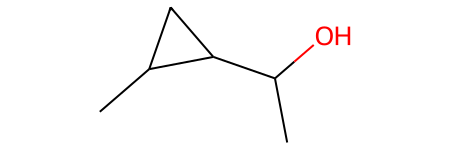

In [3]:
print('Loading data...')
start = time.time()

data_folder_pytorch = 'dataset/QM9_1.4k_pytorch/'
print(data_folder_pytorch)

with open(data_folder_pytorch+"atom_dict.pkl","rb") as f:
    atom_dict=pickle.load(f)
with open(data_folder_pytorch+"bond_dict.pkl","rb") as f:
    bond_dict=pickle.load(f)
with open(data_folder_pytorch+"test_pytorch.pkl","rb") as f:
    test=pickle.load(f)
with open(data_folder_pytorch+"val_pytorch.pkl","rb") as f:
    val=pickle.load(f)
with open(data_folder_pytorch+"train_pytorch.pkl","rb") as f:
    train=pickle.load(f)
print('Time:',time.time()-start)

print('num train data :',len(train))

print('atom_dict.idx2word :',atom_dict.idx2word)
print('atom_dict.word2idx :',atom_dict.word2idx)
print('bond_dict.idx2word :',bond_dict.idx2word)
print('bond_dict.word2idx :',bond_dict.word2idx)

num_atom_type = len(atom_dict.idx2word)
num_bond_type = len(bond_dict.idx2word)
print(num_atom_type, num_bond_type)

idx = 45
print('train[idx].atom_type :',train[idx].atom_type)
print('train[idx].atom_type_pe :',train[idx].atom_type_pe)
print('train[idx].bond_type :',train[idx].bond_type)
print('train[idx].bag_of_atoms :',train[idx].bag_of_atoms)
print('train[idx].smile: ',train[idx].smile)
mol = Chem.MolFromSmiles(train[idx].smile)
mol


# Print dataset statistics

In [4]:
# Organize data into group of of molecules of fixed sized
# Example: train[22] is a list containing all the molecules of size 22
def group_molecules_per_size(dataset):
    mydict={}
    for mol in dataset:
        if len(mol) not in mydict:
            mydict[len(mol)]=[]
        mydict[len(mol)].append(mol)
    return mydict
test_group  = group_molecules_per_size(test)
val_group   = group_molecules_per_size(val)
train_group = group_molecules_per_size(train)
print(len(train_group[8])) # QM9
# print(len(train_group[28])) # ZINC

# what is the biggest molecule in the train set
max_mol_sz= max(list( train_group.keys()))
print('Max num atoms = ', max_mol_sz)

# print distribution w.r.t. molecule size
def print_distribution(data):
    for nb_atom in range(max_mol_sz+1):
        try:
            print('number of molecule of size {}: \t {}'.format(nb_atom, len(data[nb_atom])))
        except:
            pass
print('Train'); print_distribution(train_group)
print('Val'); print_distribution(val_group)
print('Test'); print_distribution(test_group)


136
Max num atoms =  9
Train
number of molecule of size 4: 	 1
number of molecule of size 5: 	 1
number of molecule of size 6: 	 7
number of molecule of size 7: 	 24
number of molecule of size 8: 	 136
number of molecule of size 9: 	 831
Val
number of molecule of size 7: 	 6
number of molecule of size 8: 	 28
number of molecule of size 9: 	 166
Test
number of molecule of size 6: 	 1
number of molecule of size 7: 	 3
number of molecule of size 8: 	 37
number of molecule of size 9: 	 159


# Generate batch of pytorch molecules of same size

### Implement the molecule sampler class for batch sampling of molecules

In [5]:
# A class to help drawing batches of molecules having the same size
class MoleculeSampler:
    def __init__(self, organized_dataset, bs , shuffle=True):
        self.bs = bs
        self.num_mol =  { sz: len(list_of_mol)  for sz , list_of_mol in organized_dataset.items() }
        self.counter = { sz: 0   for sz in organized_dataset }
        if shuffle:
            self.order = { sz: np.random.permutation(num)  for sz , num in self.num_mol.items() }
        else:
            self.order = { sz: np.arange(num)  for sz , num in self.num_mol.items() }

    def compute_num_batches_remaining(self):
        #return {sz:  ( self.num_mol[sz] - self.counter[sz] ) // self.bs  for sz in self.num_mol}
        return {sz:  math.ceil(((self.num_mol[sz] - self.counter[sz])/self.bs))  for sz in self.num_mol}

    def choose_molecule_size(self):
        num_batches = self.compute_num_batches_remaining()
        possible_sizes =  np.array( list( num_batches.keys()) )
        prob           =  np.array( list( num_batches.values() )   )
        prob =  prob / prob.sum()
        sz   = np.random.choice(  possible_sizes , p=prob )
        return sz

    def is_empty(self):
        num_batches= self.compute_num_batches_remaining()
        return sum( num_batches.values() ) == 0

    def draw_batch_of_molecules(self, sz):
        num_batches = self.compute_num_batches_remaining()
        if (self.num_mol[sz] - self.counter[sz])/self.bs >= 1.0:
            bs = self.bs
        else:
            bs = self.num_mol[sz] - (self.num_mol[sz]//self.bs) * self.bs
        #print('sz, bs',sz, bs)
        indices = self.order[sz][ self.counter[sz] : self.counter[sz] + bs]
        self.counter[sz] += bs
        return indices


### Extract one mini-batch

In [6]:
# extract one mini-batch
bs = 50
sampler = MoleculeSampler(train_group, bs)
print('sampler.num_mol :',sampler.num_mol)
while(not sampler.is_empty()):
    num_batches_remaining = sampler.compute_num_batches_remaining()
    print('num_batches_remaining :',num_batches_remaining)
    sz = sampler.choose_molecule_size()
    print('sz :',sz)
    indices = sampler.draw_batch_of_molecules(sz)
    print('indices :',len(indices),indices)
    minibatch_node = torch.stack( [ train_group[sz][i].atom_type for i in indices] )
    print('minibatch_node :',minibatch_node.size())
    minibatch_pe  = torch.stack( [ train_group[sz][i].atom_type_pe  for i in indices] )
    print('minibatch_pe :',minibatch_pe.size())
    minibatch_edge = torch.stack( [ train_group[sz][i].bond_type for i in indices] )
    print('minibatch_edge :',minibatch_edge.size())
    minibatch_boa = torch.stack( [ train_group[sz][i].bag_of_atoms for i in indices] )
    print('minibatch_boa :',minibatch_boa.size())
    break
    print('---------------------------------------')


sampler.num_mol : {9: 831, 8: 136, 7: 24, 6: 7, 5: 1, 4: 1}
num_batches_remaining : {9: 17, 8: 3, 7: 1, 6: 1, 5: 1, 4: 1}
sz : 7
indices : 24 [ 9  8 18 14 23 21  5 22  4  0 12 10 17  6  3  2 13 16 19 15 11  1 20  7]
minibatch_node : torch.Size([24, 7])
minibatch_pe : torch.Size([24, 7])
minibatch_edge : torch.Size([24, 7, 7])
minibatch_boa : torch.Size([24, 9])


### Compute valid molecules

In [7]:
# A class to sample a molecule size w.r.t. the train distribution
class sample_molecule_size:
    def __init__(self, organized_dataset):
        self.num_mol =  { sz: len(list_of_mol)  for sz , list_of_mol in organized_dataset.items() }
        self.num_batches_remaining = { sz:  self.num_mol[sz]  for sz in self.num_mol }
    def choose_molecule_size(self):
        num_batches = self.num_batches_remaining
        possible_sizes =  np.array( list( num_batches.keys()) )
        prob           =  np.array( list( num_batches.values() )   )
        prob =  prob / prob.sum()
        sz   = np.random.choice(  possible_sizes , p=prob )
        return sz

sampler_size = sample_molecule_size(train_group)
print('sampler_size.num_mol :',sampler_size.num_mol)
sz = sampler_size.choose_molecule_size()
print('sz :',sz)


sampler_size.num_mol : {9: 831, 8: 136, 7: 24, 6: 7, 5: 1, 4: 1}
sz : 9


# Exercise 1: Design the class of dense GraphTransformer networks with edge features

Node update equation: 
$$\bar{h}^{\ell} =  h^{\ell} + \textrm{gMHA} (\textrm{LN}(h^{\ell}),\textrm{LN}(e^{\ell})) \in \mathbb{R}^{N\times d}$$
$$h^{\ell+1} = \bar{h}^{\ell} + \textrm{MLP} (\textrm{LN}(\bar{h}^{\ell}))  \in \mathbb{R}^{N\times d}$$
$$\textrm{with } \textrm{gMHA}(h,e)=\textrm{Concat}_{k=1}^H \left( \textrm{gHA}(h_k,e_k) \right) W_O \in \mathbb{R}^{N\times d},\ h_k\in \mathbb{R}^{N\times d'=d/H}, e_k\in \mathbb{R}^{N\times N\times d'}, W_O\in \mathbb{R}^{d\times d} $$
$$\quad\quad\ \textrm{gHA}(h,e)_i= \sum_{j\in V} \underbrace{\frac{\exp(q_i^T \textrm{diag}(e_{ij}) k_j/\sqrt{d'})}{ \sum_{j'\in V} \exp(q_i^T \textrm{diag}(e_{ij'}) k_{j'}/\sqrt{d'}) }}_{\textrm{graph attention score w/ edge feature}_{ij}} v_j\ \textrm{ (point-wise equation)}$$
$$\quad\quad\ Q=h_k W_Q, K=h_k W_K, V=h_k W_V\in \mathbb{R}^{N\times d'=d/H}, E=e_k W_E\in \mathbb{R}^{E\times d'=d/H}, W_Q, W_K, W_V, W_E\in \mathbb{R}^{d'\times d'}$$
$$h^{\ell=0} = \textrm{LL}_1(h_0)+\textrm{LL}_2(p_0) \in \mathbb{R}^{N\times d}\ \textrm{(input node feature and positional encoding)}$$
$$\textrm{with } p_0=\Phi_{\{2,..,K+1\}}\in \mathbb{R}^{N\times K},\ \Delta = \Phi \Lambda \Phi^T \in \mathbb{R}^{N\times N}$$


Edge update equation:  

$$\bar{e}^{\ell} =  e^{\ell} + \textrm{gMHE} (\textrm{LN}(e^{\ell}),\textrm{LN}(h^{\ell}))  \in \mathbb{R}^{N\times N\times d}$$
$$e^{\ell+1} = \bar{e}^{\ell} + \textrm{MLP} (\textrm{LN}(\bar{e}^{\ell})) \in \mathbb{R}^{N\times N\times d}$$
$$\textrm{with } \textrm{gMHE}(e,h)=\textrm{Concat}_{k=1}^H \left( \textrm{gHE}(e_k,h_k) \right) W_O^e \in \mathbb{R}^{N\times N\times d},\ h_k\in \mathbb{R}^{N\times d'=d/H}, e_k\in \mathbb{R}^{N\times N\times d'}, W_O^e\in \mathbb{R}^{d\times d} $$
$$\textrm{with } \textrm{gHE}(e,h)_{ij}=q_i \odot e_{ij} \odot k_j/\sqrt{d'} \in \mathbb{R}^{d'} \textrm{ (point-wise equation)}$$
$$e^{\ell=0} = \textrm{LL}(e_0) \in \mathbb{R}^{N\times N\times d}\ \textrm{(input edge feature)}$$


Differences between sparse GT and dense GT:
- The edge features are now dense : Sparse $e\in \mathbb{R}^{E\times d}$ to $e\in \mathbb{R}^{N\times N\times d}$.
- The absence of edges in the graph is now considered as a bond type e.g. `None` type with integer value `0`.
- The attention function is now connected to all nodes in the graph : Sparse attention with $\sum_{j\in \mathcal{N}_i}$ to dense attention $\sum_{j\in V}$.


In [9]:
# Global constants
num_heads = 8; d = 16*num_heads; num_layers = 4; drop = 0.0; bs = 50
print('d, num_heads, num_layers, drop : ', d, num_heads, num_layers, drop)

# Warmup
num_mol_size = 20
num_warmup = 2 * max( num_mol_size, len(train) // bs ) # 4 epochs * max( num_mol_size=20, num_mol/batch_size)
print('num_warmup :',num_warmup)


d, num_heads, num_layers, drop :  128 8 4 0.0
num_warmup : 40


### Implement the Graph Transformer architecture

In [10]:
# Define Graph Transformer architecture
class head_attention(nn.Module):
    def __init__(self, d, d_head):
        super().__init__()
        self.Q = nn.Linear(d, d_head)
        self.K = nn.Linear(d, d_head)
        self.E = nn.Linear(d, d_head)
        self.V = nn.Linear(d, d_head)
        self.sqrt_d = torch.sqrt(torch.tensor(d_head))
        self.drop_att = nn.Dropout(drop)
        self.Ni = nn.Linear(d, d_head)
        self.Nj = nn.Linear(d, d_head)

    def forward(self, x, e):
        Q = self.Q(x) # [bs, n, d_head]
        K = self.K(x) # [bs, n, d_head]
        V = self.V(x) # [bs, n, d_head]
        Q = Q.unsqueeze(2) # [bs, n, 1, d_head]
        K = K.unsqueeze(1) # [bs, 1, n, d_head]
        E = self.E(e) # [bs, n, n, d_head]
        Ni = self.Ni(x).unsqueeze(2) # [bs, n, 1, d_head]
        Nj = self.Nj(x).unsqueeze(1) # [bs, 1, n, d_head]
        e = Ni + Nj + E
        Att = (Q * e * K).sum(dim=3) / self.sqrt_d # [bs, n, n]
        Att = torch.softmax(Att, dim=1) # [bs, n, n]
        Att = self.drop_att(Att)
        x = Att @ V  # [bs, n, d_head]
        return x, e

### Question 1.1: Implement a **dense** Graph Multi-Head Attention (MHA) Layer with Pytorch

**Instructions:**

- *Step 1:* Pass node feature and edge features along edges.

- *Step 2:* Update node feature and edge features. You may use ```torch.cat()``` for concatenating vectors.

In [11]:
class MHA(nn.Module):
    def __init__(self, d, num_heads):
        super().__init__()
        d_head = d // num_heads
        self.heads = nn.ModuleList( [head_attention(d, d_head) for _ in range(num_heads)] )
        self.WOx = nn.Linear(d, d)
        self.WOe = nn.Linear(d, d)
        self.drop_x = nn.Dropout(drop)
        self.drop_e = nn.Dropout(drop)

    def forward(self, x, e):
        x_MHA = []
        e_MHA = []
        for head in self.heads:
            ###############################################
            # YOUR CODE STARTS
            ###############################################
            # Step 1: Pass node feature and edge features along edges.
            x_HA, e_HA = head(x, e)
            ###############################################
            # YOUR CODE ENDS
            ###############################################

            x_MHA.append(x_HA)
            e_MHA.append(e_HA)

        ###############################################
        # YOUR CODE STARTS
        ###############################################
        # Step 2: Update node features
        x = self.WOx(torch.cat(x_MHA, dim=2)) # [bs, n, d]
        x = self.drop_x(x)

        # Step 2: Update edge features
        e = self.WOe(torch.cat(e_MHA, dim=3)) # [bs, n, n, d]
        e = self.drop_e(e)
        ###############################################
        # YOUR CODE ENDS
        ###############################################

        return x, e



### Question 1.2: Implement a **dense** GraphTransformer layer

**Instructions:**

- *Layer normalization:* Intialize two layer normalization ```nn.LayerNorm(input_dim)``` for  edge features.

- *Input embedding layer:* Initialize a linear layer ```nn.Linear()``` to convert input edge features into edge embeddings.

- *Graph transformer layer:* Initialize a graph Transformer layer using the defined ```MHA()``` class.

- *MLP layer:* Initialize a MLP layer ```nn.Sequential(nn.Linear(input_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, output_dim))``` for edge features.

In [12]:
class BlockGT(nn.Module):
    def __init__(self, d, num_heads):
        super().__init__()
        # Intialize two layer normalization for node features
        self.LNx = nn.LayerNorm(d)
        self.LNx2 = nn.LayerNorm(d)

        # Intialize a MLP layer for node features
        self.MLPx = nn.Sequential(nn.Linear(d, 4*d), nn.ReLU(), nn.Linear(4*d, d))

        # Intialize the graph Transformer layer
        self.MHA = MHA(d, num_heads)

        # Intialize a dropout layer for node features
        self.drop_x_mlp = nn.Dropout(drop)

        ###############################################
        # YOUR CODE STARTS
        ###############################################
        # Intialize two layer normalization for edge features
        self.LNe =  nn.LayerNorm(d)
        self.LNe2 =  nn.LayerNorm(d)

        # Intialize a MLP layer for edge features
        self.MLPe =  nn.Sequential(nn.Linear(d, 4*d), nn.ReLU(), nn.Linear(4*d, d))

        # Intialize a dropout layer for edge features
        self.drop_x_mlp =  nn.Dropout(drop)
        self.drop_e_mlp =  nn.Dropout(drop)
        ###############################################
        # YOUR CODE ENDS
        ###############################################

    def forward(self, x, e):
        # Implement layer normalization for node and edge features, respectively
        x = self.LNx(x)
        e = self.LNe(e)

        # Implement graph Transformer
        x_MHA, e_MHA = self.MHA(x, e) # [bs, n, d], [bs, n, n, d]

        # Implement residual connection layers for node features
        x = x + x_MHA # [bs, n, d]
        x = x + self.MLPx(self.LNx2(x)) # [bs, n, d]

        x = self.drop_x_mlp(x)

        ###############################################
        # YOUR CODE STARTS
        ###############################################
        # Implement residual connection and dropout for edge features like the above operators for node features
        e = e + e_MHA # [bs, n, n, d]
        e = e + self.MLPe(self.LNe2(e)) # [bs, n, n, d]

        e = self.drop_e_mlp(e)
        ###############################################
        # YOUR CODE ENDS
        ###############################################

        return x, e



In [13]:
def sym_tensor(x):
    x = x.permute(0,3,1,2)
    triu = torch.triu(x,diagonal=1).transpose(3,2)
    mask = (triu.abs()>0).float()
    x =  x * (1 - mask ) + mask * triu
    x = x.permute(0,2,3,1)
    return x

class GT(nn.Module):
    def __init__(self):
        super().__init__()
        self.atom_emb = nn.Embedding(num_atom_type, d)
        self.bond_emb = nn.Embedding(num_bond_type, d)
        num_layers_encoder = 4
        self.BlockGT_encoder_layers = nn.ModuleList( [BlockGT(d, num_heads) for _ in range(num_layers_encoder)] )
        self.ln_x_final = nn.LayerNorm(d)
        self.linear_x_final = nn.Linear(d, 1, bias=True)
        self.drop_x_emb = nn.Dropout(drop)
        self.drop_e_emb = nn.Dropout(drop)
    def forward(self, x, e):

        # input layer
        x = self.atom_emb(x)                   # [bs, n, d]
        e = self.bond_emb(e)                   # [bs, n, n, d]
        e = sym_tensor(e)                      # [bs, n, n, d]
        x = self.drop_x_emb(x)
        e = self.drop_e_emb(e)

        # encoder
        for gt_layer in self.BlockGT_encoder_layers:
            x, e = gt_layer(x, e)  # [bs, n, d],  [bs, n, n, d]
            e = sym_tensor(e)

        # class token
        mol_token = x.mean(1) # [bs, d]

        # regressor
        x = self.ln_x_final(mol_token)
        x = self.linear_x_final(x)

        return x

try:
    del net
except:
  print("First run")



First run


### Instantiate a **dense** graph Transformer network

In [14]:
# Instantiate the network
net = GT()
net = net.to(device)
def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('Number of parameters: {} ({:.2f} million)'.format(nb_param, nb_param/1e6))
    return nb_param/1e6
_ = display_num_param(net)




Number of parameters: 1588225 (1.59 million)


### Test the forward pass, backward pass and gradient update with a single batch

In [15]:
# Test the forward pass, backward pass and gradient update with a single batch
init_lr = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=init_lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.95, patience=1, verbose=True)

bs = 50
sampler = MoleculeSampler(train_group, bs)
print('sampler.num_mol :',sampler.num_mol)
num_batches_remaining = sampler.compute_num_batches_remaining()
print('num_batches_remaining :',num_batches_remaining)
sz = sampler.choose_molecule_size()
print('sz :',sz)
indices = sampler.draw_batch_of_molecules(sz)
print('indices :',len(indices),indices)
batch_x0 = minibatch_node = torch.stack( [ train_group[sz][i].atom_type for i in indices] ).long().to(device) # [bs, n]
print('minibatch_node :',minibatch_node.size())
batch_e0 = minibatch_edge = torch.stack( [ train_group[sz][i].bond_type for i in indices] ).long().to(device) # [bs, n, n]
print('minibatch_edge :',minibatch_edge.size())
batch_target = torch.stack( [ train_group[sz][i].logP_SA_cycle_normalized for i in indices] ).float().to(device) # [bs, 1]
print('batch_target :',batch_target.size())

batch_x_pred = net(batch_x0, batch_e0) # [bs, 1]
print('batch_x_pred',batch_x_pred.size())

loss = nn.L1Loss()(batch_x_pred, batch_target)
optimizer.zero_grad()
loss.backward()
optimizer.step()


sampler.num_mol : {9: 831, 8: 136, 7: 24, 6: 7, 5: 1, 4: 1}
num_batches_remaining : {9: 17, 8: 3, 7: 1, 6: 1, 5: 1, 4: 1}
sz : 9
indices : 50 [628 550 133 589 319 305 130 537   9 311 408 336 636 730 806  87  78 267
 458 699  44 369 540 740 331 585 499 162 742 647 121 199 450 231 233 717
 727 708 472 398 519  94 337 738 551 320 614 351 821  47]
minibatch_node : torch.Size([50, 9])
minibatch_edge : torch.Size([50, 9, 9])
batch_target : torch.Size([50, 1])
batch_x_pred torch.Size([50, 1])


### Train the network

In [ ]:
# Training loop
del net
net = GT()
net = net.to(device)
_ = display_num_param(net)

# Optimizer
init_lr = 0.0003
init_lr = 0.0001
optimizer = torch.optim.Adam(net.parameters(), lr=init_lr)
scheduler_warmup = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda t: min((t+1)/num_warmup, 1.0) ) # warmup scheduler
scheduler_tracker = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.95, patience=1, verbose=True) # tracker scheduler

num_warmup_batch = 0

# Number of mini-batches per epoch
nb_epochs = 100

lossMAE = nn.L1Loss()

print('num batch(before scheduler_tracker), num epoch(before scheduler_tracker), num_warmup_batch(current):', \
      num_warmup, num_warmup//(len(train)//bs), num_warmup_batch)

total_loss = moving_loss = -1
list_loss = []
start=time.time()
for epoch in range(nb_epochs):

    running_loss = 0.0
    num_batches = 0
    num_data = 0
    net.train()

    bs = 50
    sampler = MoleculeSampler(train_group, bs)
    #print('sampler.num_mol :',sampler.num_mol)
    while(not sampler.is_empty()):
        num_batches_remaining = sampler.compute_num_batches_remaining()
        #print('num_batches_remaining :',num_batches_remaining)
        sz = sampler.choose_molecule_size()
        #print('sz :',sz)
        indices = sampler.draw_batch_of_molecules(sz)
        bs2 = len(indices)
        #print('indices :',len(indices),indices)
        batch_x0 = minibatch_node = torch.stack( [ train_group[sz][i].atom_type for i in indices] ).long().to(device) # [bs, n]
        #print('minibatch_node :',minibatch_node.size())
        batch_e0 = minibatch_edge = torch.stack( [ train_group[sz][i].bond_type for i in indices] ).long().to(device) # [bs, n, n]
        #print('minibatch_edge :',minibatch_edge.size())
        batch_target = torch.stack( [ train_group[sz][i].logP_SA_cycle_normalized for i in indices] ).float().to(device) # [bs, 1]

        batch_x_pred = net(batch_x0, batch_e0) # [bs, 1]

        loss = lossMAE(batch_x_pred, batch_target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if num_warmup_batch < num_warmup:
            scheduler_warmup.step() # warmup scheduler
        num_warmup_batch += 1

        # COMPUTE STATS
        running_loss += bs2 * loss.detach().item()
        num_batches += 1
        num_data += bs2


    # TEST SET
    bs = 50
    sampler = MoleculeSampler(test_group, bs)
    running_test_loss = 0
    num_test_data = 0
    with torch.no_grad():
        while(not sampler.is_empty()):
            num_batches_remaining = sampler.compute_num_batches_remaining()
            sz = sampler.choose_molecule_size()
            indices = sampler.draw_batch_of_molecules(sz)
            bs2 = len(indices)
            batch_x0 = minibatch_node = torch.stack( [ test_group[sz][i].atom_type for i in indices] ).long().to(device) # [bs, n]
            batch_e0 = minibatch_edge = torch.stack( [ test_group[sz][i].bond_type for i in indices] ).long().to(device) # [bs, n, n]
            batch_target = torch.stack( [ test_group[sz][i].logP_SA_cycle_normalized for i in indices] ).float().to(device) # [bs, 1]
            batch_x_pred = net(batch_x0, batch_e0) # [bs, 1]
            running_test_loss += bs2 * lossMAE(batch_x_pred, batch_target).detach().item()
            num_test_data += bs2


    # AVERAGE STATS THEN DISPLAY
    mean_train_loss = running_loss/num_data
    mean_test_loss = running_test_loss/num_test_data
    if num_warmup_batch >= num_warmup:
        scheduler_tracker.step(mean_train_loss) # tracker scheduler defined w.r.t. loss value
        num_warmup_batch += 1
    elapsed = (time.time()-start)/60
    if not epoch%1:
        line = 'epoch= ' + str(epoch) + '\t time= ' + str(elapsed)[:6] + ' min' + '\t lr= ' + \
        '{:.7f}'.format(optimizer.param_groups[0]['lr']) + '\t train_loss= ' + str(mean_train_loss)[:6] + \
        '\t test_loss= ' + str(mean_test_loss)[:6]
        print(line)

    # Check lr value
    if optimizer.param_groups[0]['lr'] < 10**-6: # 2*10**-4: quick, # 10**-6: slow
      print("\n lr is equal to min lr -- training stopped\n")
      break



Number of parameters: 1588225 (1.59 million)
num batch(before scheduler_tracker), num epoch(before scheduler_tracker), num_warmup_batch(current): 40 2 0
epoch= 0	 time= 0.1507 min	 lr= 0.0000625	 train_loss= 1.3433	 test_loss= 1.3361
epoch= 1	 time= 0.3034 min	 lr= 0.0001000	 train_loss= 1.3012	 test_loss= 1.2879
epoch= 2	 time= 0.4542 min	 lr= 0.0001000	 train_loss= 1.3172	 test_loss= 1.2690
Epoch 00003: reducing learning rate of group 0 to 9.5000e-05.
epoch= 3	 time= 0.5996 min	 lr= 0.0000950	 train_loss= 1.3112	 test_loss= 1.2511
epoch= 4	 time= 0.7541 min	 lr= 0.0000950	 train_loss= 1.2974	 test_loss= 1.2497
epoch= 5	 time= 0.9017 min	 lr= 0.0000950	 train_loss= 1.2882	 test_loss= 1.2425
epoch= 6	 time= 1.0475 min	 lr= 0.0000950	 train_loss= 1.2836	 test_loss= 1.2456
epoch= 7	 time= 1.1929 min	 lr= 0.0000950	 train_loss= 1.3041	 test_loss= 1.2356
epoch= 8	 time= 1.3105 min	 lr= 0.0000950	 train_loss= 1.2544	 test_loss= 1.2858
epoch= 9	 time= 1.4247 min	 lr= 0.0000950	 train_loss= 1

## Compare results

| GNN    | train MAE | test MAE |
| -------- | ------- | ------- |
| Sparse GT (DGL)   | 0.4483    | 0.7327    |
| Dense GT (PyTroch)    |  0.5464   | 0.6954   |
